# Загрузка библиотек

In [1]:
# Подключим необходимые библиотеки
import numpy as np                                        # базовые операции с массивами
import pandas as pd                                       # базовые операции с датафреймами
import scipy as scipy
from copy import deepcopy
import math
from scipy.stats import multivariate_normal
import seaborn
import matplotlib.pyplot as plt
import doubleml as dml
from sklearn.ensemble import RandomForestClassifier       # случайный лес (классификация)
from sklearn.ensemble import RandomForestRegressor        # случайный лес (регрессия)
from sklearn.ensemble import GradientBoostingClassifier   # градиентный бустинг (классификация)
from sklearn.ensemble import GradientBoostingRegressor    # градиентный бустинг (регрессия)
from sklearn.linear_model import Lasso                    # Лассо
from sklearn.base import clone
import statsmodels.api as sm  # линейная регрессия

# Генерация данных и предварительная обработка данных

Предположим, что заработная плата $Y_{i}=\text{Wage}_{i}$ зависит от таких признаков $X_{i}$ как:


*   $\text{Sport_activities }_{ i}$ - факт занятий спортом ($1$ - да, $0$ - нет)
*   $\text{Education}_{i}$ -  количество лет получения образования
*   $\text{Health}_{i}$ - здоровье ($1$ - есть, $0$ - нет)
*   $\text{Age}_{i}$ - возраст
*   $\text{Stress}_{i}$ - наличие стресса у индивида (1 - есть стресс, 0 - нет)

*   $\text{Abilities}_{i}$ - способности

Также, в данных имеется информация о наличии рядом спортзала/парка для занятий спортом $\text{GYM_distance}_{i}$ ($1$ - есть близко, $0$ - нет), которое будет использоваться в качестве инструментальной переменной.

Опишем процесс генерации данных в общем виде. При этом будем рассматривать процесс генерации данных, предполагаемый двойным машинным обучением (ДМО / DML).

**Целевая переменная**:

$$\text{Wage}_{i} = \alpha \text{Sport_activities}_{i} + g(\text{Education}_{i},\text{Health}_{i},\text{Age}_{i},\text{Stress}_{i}) + \varepsilon_{i}^{\text{Wage}}$$

**Переменная воздействия**:

$$\text{Sport_activities}_{i} = g_{\text{Sport_activities}}(\text{Education}_{i},\text{Health}_{i},\text{Age}_{i},\text{Stress}_{i}) + \varepsilon_{i}^{\text{Sport_activities}}$$


**Инструментальная переменная**:

$$\text{GYM_distance}_{i} = g_{\text{GYM_distance}}(\text{Education}_{i},\text{Health}_{i},\text{Age}_{i},\text{Stress}_{i}) + \varepsilon_{i}^{\text{GYM_distance}}$$

В данном случае нас не интересует получение точных прогнозов заработной платы $\text{Wage}_{i}$.

**Цель** - получить как можно более точную оценку параметра $\alpha$, отражающего влияние занятий спортом $\text{Sport_activities}_{i}$ на заработную плату $\text{Wage}_{i}$.

**Интерпретация** - занятия спортом $\text{Sport_activities}_{i} = 1$, при прочем равном образовании, здоровье, возрасте,  и уровне стресса, повышает заработную плату $\text{Wage}_{i}$ на $\alpha$.

**Допущения о распределении - скажем "НЕТ" ЭНДОГЕННОСТИ!**

Все переменные и случайные ошибки предполагаются независимыми и одинаково распределенными между наблюдениями, то есть по $i\in\{1,...n\}$, где $n$ - число наблюдений.

$$\text{E}(\varepsilon^{\text{Wage}}_{i}|\text{Education}_{i}, \text{Health}_{i},\text{Age}_{i},\text{Stress}_{i},\text{GYM_distance}_{i})=0$$

$$\text{E}(\varepsilon^{\text{Sport_activities}}_{i}|\text{Education}_{i}, \text{Health}_{i},\text{Age}_{i},\text{Stress}_{i})=0$$

$$\text{E}(\varepsilon^{\text{GYM_distance}}_{i}|\text{Education}_{i}, \text{Health}_{i},\text{Age}_{i},\text{Stress}_{i})=0$$

In [2]:
# Число наблюдений
n = 10000

# Для воспроизводимости
np.random.seed(123)

Симулируем контрольные непрерывные переменные $\text{Education}_{i}$, $\text{Age}_{i}$ и $\text{Abilities}_{i}$  из нормального распределения с математическим ожиданием $\mu=11$,$ \mu=45$,$\mu=25$ и стандартным отклонением $\sigma=6$, $ \sigma=25$, $ \sigma=10$ соответсвенно, то есть $\text{N}\left(11, 6^2\right)$, $\text{N}\left(45, 25^2\right)$, $\text{N}\left(25, 10^2\right)$. Для удобства также усечем эти распределения сверху и снизу, а после этого округлим полученные значения. А $\text{Health}_{i}$, $\text{Stress}_{i}$ из распределения биномиального с вероятностями 0,5 и 0,1 соответсвенно.

In [3]:
# Количество лет получения образования
education = scipy.stats.norm.rvs(size = n,                   # генерация
                              loc = 11, scale = 6)
education[education >= 30] = 30                                 # усечение
education[education <= 4] = 4
education = np.round(education)                                 # округление
print({'education': education[0:10]})                           # первые 10 наблюдений

# Здоровье
health = np.random.binomial(1, 0.5, n)                    # генерация
print({'health': health[0:10]})                           # первые 10 наблюдений

# Возраст
age = scipy.stats.norm.rvs(size = n,                   # генерация
                              loc = 45, scale = 25)
age[age >= 80] = 80                                 # усечение
age[age <= 14] = 14
age = np.round(age)                                 # округление
print({'Age': age[0:10]})                           # первые 10 наблюдений

# Уровень стресса
stress = np.random.binomial(1, 0.1, n)                    # генерация
print({'stress': stress[0:10]})                           # первые 10 наблюдений

# Способности
abilities = scipy.stats.norm.rvs(size = n,
                                 loc = 25, scale = 10)    # генерация
abilities[abilities >= 50] = 50                           # усечение
abilities[abilities <= 1] = 1
abilities = np.round(abilities)                           # округление
print({'abilities': abilities[0:10]})                     # первые 10 наблюдений

{'education': array([ 4., 17., 13.,  4.,  8., 21.,  4.,  8., 19.,  6.])}
{'health': array([1, 1, 0, 0, 1, 0, 1, 1, 0, 0])}
{'Age': array([37., 50., 42., 79., 44., 45., 69., 14., 14., 49.])}
{'stress': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
{'abilities': array([14.,  1.,  1., 35., 23., 27., 13., 44., 37., 18.])}


Применим фантазию 🦄 и симулируем инструментальную переменную: отдаленность спортивного зала/места для занятий спортом  от места проживания $\text{GYM_distance}_{i}$.

Для краткости обозначим $X_{i}=(\text{Education}_{i}, \text{Health}_{i}, \text{Age}_{i}, \text{Stress}_{i})$.

Необходимо симулировать переменную $\text{GYM_distance}_{i}$ так, чтобы она была представима в виде:

$$\text{GYM_distance}_{i} = g_{\text{GYM_distance}}(X_{i}) + \varepsilon^{\text{GYM_distance}}_{i} $$

При этом необходимо соблюсти:

$$\text{E}(\varepsilon^{\text{GYM_distance}}_{i}|X_{i})=0$$

Для этого рассмотрим:

$$\varepsilon^{\text{GYM_distance}}_{i} = \text{GYM_distance}_{i} - \text{E}(\text{GYM_distance}_{i}|X_{i})$$

Действительно, в таком случае $\text{E}(\varepsilon^{\text{GYM_distance}}_{i}|X_{i})=0$, поскольку:

$$\text{E}(\varepsilon^{\text{GYM_distance}}_{i}|X_{i}) = \text{E}(\text{GYM_distance}_{i}|X_{i}) - \text{E}(\text{E}(\text{GYM_distance}_{i}|X_{i})|X_{i})=
\text{E}(\text{GYM_distance}_{i}|X_{i})-\text{E}(\text{GYM_distance}_{i}|X_{i})=0$$

Из полученного результата следует, что $g_{\text{GYM_distance}}(X_{i}) = \text{E}(\text{GYM_distance}_{i}|X_{i})$ является достаточным условием для $E(\varepsilon^{\text{GYM_distance}}_{i}|X_{i})=0$, что мотивирует запись:

$$\text{GYM_distance}_{i} = \underbrace{\text{E}(\text{GYM_distance}_{i}|X_{i})}_{g_{\text{GYM_distance}}(X_{i})} + \varepsilon^{\text{GYM_distance}}_{i} $$

**Проблема** - из полученного результата все еще не ясно, как генерировать $\text{GYM_distance}_{i}$ таким образом, чтобы получилась бинарная переменная.

**Решение** - понять, как в данном случае будут выглядеть условные вероятности, зная которые мы можем генерировать значения $\text{GYM_distance}_{i}$ с соответствующими вероятностями.

Обратим внимание, что поскольку $\text{GYM_distance}_{i}$ является бинарной переменной, то имеет распределение Бернулли, а значит условное математическое ожидание и условная вероятность совпадают:

$$\text{E}(\text{GYM_distance}_{i}|X_{i}) = 1\times P(\text{GYM_distance}_{i} = 1|X_{i}) + 0\times P(\text{GYM_distance}_{i} = 0|X_{i}) = P(\text{GYM_distance}_{i} = 1|X_{i})$$

Следовательно, функция $g_{\text{GYM_distance}}(X_{i})$ будет совпадать с условными вероятностями и можно рассмотреть, например, следующую спецификацию:


$$g_{\text{GYM_distance}}(X_{i}) = P(\text{GYM_distance}_{i} = 1|X_{i}) = \underbrace{F_{\text{Student}}\left(\ln\left(\text{Age}_{i}+\text{Education}_{i}\right)+\text50*{Health}_{i}-\text30*{Stress}_{i}+ \text{Age}_{i}*\text{Health}_{i}-\text{Age}_{i}*\text{Stress}_{i}+\text{Education}_{i}*\text{Health}_{i}-\text{Education}_{i}*\text{Stress}_{i}-80\right)}_{\text{из воображения}}$$

Где $F_{\text{Student}}$ - функция распределения, относящаяяся к распределению Стьюдента с $5$-ю степенями свободы. Она гарантирует, что все вероятности будут в диапазоне от $0$ до $1$.

**Общий алгоритм генерации** $\text{GYM_distance}_{i}$:

*   Берем любую функцию, принимающую значения от $0$ до $1$, например, функцию распределения любого распределения $F$. Для удобства лучше использовать непрерывные распределения с носителем на $R$.
*   В качестве аргумента этой функции рассматривается любая (желательно дифференцируемая) функция от признаков $h(X_{i})$.
*   В результате получаем условные вероятности $P\left(\text{GYM_distance}_{i}=1|X_{i}\right)=F(h(X_{i}))$, с которыми затем генерируются значения переменной $\text{GYM_distance}_{i}$.
*  Смотрим на долю $1$ переменной $\text{GYM_distance}_{i}$, чтобы она равнялась адекватному (реалистичному) значению. Если значение нас не устраивает, нужно изменить функцию от признаков $X_{i}$, например, отняв (если доля слишком велика) или прибавив (если доля слишком мала) некоторую константу к $h(X_{i})$.

In [4]:
# Условная вероятность наличия спортзала рядом с местом проживания
gym_distance_prob = scipy.stats.t.cdf(x = np.log(age + education) + 50*health - 30*stress + age*health - age*stress + education*health - education*stress - 80, df = 5)

# Факт наличия спортзала рядом с местом проживания
gym_distance = np.random.binomial(n = 1, p = gym_distance_prob, size = n)

# Первые несколько значений условных вероятностей и переменной
print(pd.DataFrame({'P(GYM_distance = 1|X)': np.round(gym_distance_prob[0:10], 2),
                    'GYM_distance': gym_distance[0:10]}))

# Доля индивидов, у которых спортзала находится рядом с местом проживания
print(pd.DataFrame(data    =  np.mean(gym_distance),
                   index   = ['P(GYM_distance = 1)'],
                   columns = ['Оценка']))

   P(GYM_distance = 1|X)  GYM_distance
0                    1.0             1
1                    1.0             1
2                    0.0             0
3                    0.0             0
4                    1.0             1
5                    0.0             0
6                    1.0             1
7                    0.0             0
8                    0.0             0
9                    0.0             0
                     Оценка
P(GYM_distance = 1)  0.4172


Применим фантазию 🦄 и симулируем переменную воздействия: факт занятий спортом $\text{Sport_activities}_{i}$.

Для краткости обозначим $X_{i}=(\text{Education}_{i}, \text{Health}_{i},\text{Age}_{i},\text{Stress}_{i})$ и $\tilde{X}_{i} = (\text{Education}_{i}, \text{Health}_{i}, \text{Age}_{i}, \text{Stress}_{i},\text{Abilities}_{i}, \text{GYM_distance}_{i})$.

**Проблема** - в данном случае нельзя действовать по аналогии с переменной $\text{GYM_distance}_{i}$, поскольку из содержательных соображений нужно также гарантировать, что $\text{Sport_activities}_{i}$ будут связаны не только с $\text{Education}_{i}$, $\text{Health}_{i}$,$\text{Age}_{i}$ и $\text{Stress}_{i}$, но и с $\text{GYM_distance}_{i}$ и $\text{Abilities}_{i}$.

**Решение** - как бы мы не симулировали связь между $\text{Sport_activities}_{i}$ и другими переменными, мы всегда (за исключением некоторых вырожденных случаев) можем предположить $g_{\text{Sport_activities}}(X_{i}) = \text{E}(\text{Sport_activities}_{i}|X_{i})$ и представить полученную модель в виде:

$$\text{Sport_activities}_{i} = \text{E}(\text{Sport_activities}_{i}|X_{i}) + \varepsilon_{i}^{\text{Sport_activities}} = g_{\text{Sport_activities}}(X_{i}) + \varepsilon_{i}^{\text{Sport_activities}}$$

При этом нам не обязательно знать и симулировать саму функцию $g_{\text{Sport_activities}}(X_{i})$, достаточно лишь того, что она будет существовать, поскольку совпадает с условным математическим ожиданием $\text{E}(\text{Sport_activities}_{i}|X_{i})$, что гарантирует $\text{E}(\varepsilon_{i}^{\text{Sport_activities}}|X_{i})=0$.

Таким образом, в симуляциях мы можем отталкиваться от вероятностей, условных на $\tilde{X}_{i}$, а не только на $X_{i}$.

$$P(\text{Sport_activities}_{i} = 1|\tilde{X}_{i}) = \underbrace{F_{\text{Logistic}}(2\times\sqrt{\text{Abilities}_{i}+\text{Education}_{i}+\text{Age}_{i}+\text{Age}_{i}*\text{Health}_{i}-\text{Age}_{i}*\text{Stress}_{i}+\text{Education}_{i}*\text{Health}_{i}-\text{Education}_{i}*\text{Stress}_{i}  + 20\times\text{GYM_distance}_{i}} - 23)}_{\text{из воображения}}$$

Где $F_{\text{Logistic}}$ - функция распределения стандартного логистического распределения.



In [5]:
# Условная вероятность наличия у индивида высшего образования
sport_activities_prob = scipy.stats.logistic.cdf(
    2 * np.sqrt(abilities + education + age + age*health - age*stress + education*health - education*stress + 50 * gym_distance) - 23)
# Факт наличия у индивида высшего образования
sport_activities = np.random.binomial(n = 1, p = sport_activities_prob, size = n)

# Первые несколько значений условных вероятностей переменной
print({'sport_activities': sport_activities[0:10]})
print(pd.DataFrame({'P(sport_activities = 1|X)': np.round(sport_activities_prob[0:10], 2),
                    'sport_activities': sport_activities[0:10]}))

# Доля индивидов с высшим образованием
print(pd.DataFrame(data    =  np.mean(sport_activities),
                   index   = ['P(sport_activities= 1)'],
                   columns = ['Оценка']))
#По данным совместного опроса ВТБ и банка «Открытие», почти половина (44%) россиян регулярно занимаются физкультурой и разными видами спорта.

{'sport_activities': array([1, 1, 0, 0, 1, 0, 1, 0, 0, 0])}
   P(sport_activities = 1|X)  sport_activities
0                       0.76                 1
1                       0.99                 1
2                       0.00                 0
3                       0.22                 0
4                       0.97                 1
5                       0.02                 0
6                       1.00                 1
7                       0.01                 0
8                       0.00                 0
9                       0.00                 0
                        Оценка
P(sport_activities= 1)  0.4057


In [6]:
# Убедимся в наличии корреляции между фактом занятий спортом,
# отдаленности спортивного зала и способностями
print(np.round(np.corrcoef([sport_activities,gym_distance,abilities]), 2))

[[ 1.    0.88  0.05]
 [ 0.88  1.   -0.02]
 [ 0.05 -0.02  1.  ]]


In [7]:
np.corrcoef(sport_activities,gym_distance)
# между интересующей нас переменной воздействия (факт занятий спортом) и инструментальной переменной (отдаленность спортивного зала) есть корреляция - прекрасно

array([[1.        , 0.88071496],
       [0.88071496, 1.        ]])

In [8]:
np.corrcoef(sport_activities,abilities)
# между интересующей нас переменной воздействия (факт занятий спортом) и эндогенной переменной (способности) есть корреляция
# результат может быть biased
# для того, чтобы избавиться от этого используем инструментальную переменную

array([[1.        , 0.04765804],
       [0.04765804, 1.        ]])

In [9]:
np.corrcoef(abilities,gym_distance) # между инструментальной (отдаленность спортивного зала )  и эндогенной переменной  (способности) почти нет корреляции - прекрасно

array([[ 1.        , -0.01936939],
       [-0.01936939,  1.        ]])

Применим фантазию 🦄 и для простоты **сперва** рассмотрим случай **без** эндогенности, то есть когда переменная $\text{Abilities}_{i}$ имеется в данных, а значит уравнение заработной платы можно рассматривать в форме:

$$\text{Wage}_{i} = \alpha \text{Sport_activities}_{i} + g(\text{Education}_{i}, \text{Health}_{i},\text{Age}_{i},\text{Stress}_{i}, \text{Abilities}_{i}) + \varepsilon_{i}^{\text{Wage}}$$

Предположим (из воображения), что случайная ошибка $\varepsilon_{i}^{\text{Wage}}$ была получена из экспоненциального распределения с параметром $\lambda = 0.01$ и стандартизирована к нулевому математическому ожиданию.

Допустим, что неизвестная исследователю функция имеет вид:

$$g(\text{Education}_{i}, \text{Health}_{i}, \text{Age}_{i},\text{Stress}_{i}\text{Abilities}_{i}) = \underbrace{\text{Abilities}_{i} + 20\times\frac{5\times\text({Age}_{i}+{Education}_{i}) - 0.06\times\text({Age}_{i}^2+{Education}_{i}^2)}{100-\text30*{Health}_{i}+\text10*{Stress}_{i}}}_{\text{из воображения}}$$

In [10]:
# Случайная ошибка
error_wage = scipy.stats.expon.rvs(size = n, scale = 10, loc = 0) - 10

# Отдача от Sport_activities
alpha = 10

# Функция от контрольных переменных
g = abilities + 20 * (5* (age + education) - 0.06 * (age ** 2 + education ** 2)) / (100 - 30*health + 10*stress)

# Зарплата
wage = alpha * sport_activities + g + error_wage

In [11]:
# Корреляция между всеми переменными
print(np.round(np.corrcoef([sport_activities, gym_distance, abilities, age, health,stress,education,wage]), 2))

[[ 1.    0.88  0.05  0.26  0.73 -0.26  0.08  0.52]
 [ 0.88  1.   -0.02  0.13  0.83 -0.29  0.06  0.5 ]
 [ 0.05 -0.02  1.   -0.01 -0.01  0.01 -0.01  0.52]
 [ 0.26  0.13 -0.01  1.    0.   -0.01 -0.01 -0.08]
 [ 0.73  0.83 -0.01  0.    1.   -0.01 -0.    0.45]
 [-0.26 -0.29  0.01 -0.01 -0.01  1.   -0.01 -0.12]
 [ 0.08  0.06 -0.01 -0.01 -0.   -0.01  1.    0.25]
 [ 0.52  0.5   0.52 -0.08  0.45 -0.12  0.25  1.  ]]


In [12]:
has_negative = np.any(g < 0)
has_negative
# проверка того, что отрицательных зарплат у нас нет

False

In [13]:
# Аггрегируем данные в датафрейм
df = pd.DataFrame({'sport_activities': sport_activities,'education': education,
                   'health': health, 'age': age,'stress': stress,'abilities': abilities,
                   'GYM_distance': gym_distance, 'wage': wage})

# Посмотрим на симулированные данные
df

,sport_activities,education,health,age,stress,abilities,GYM_distance,wage
0,1,4.0,1,37.0,0,14.0,1,52.314629
1,1,17.0,1,50.0,0,1.0,1,74.630682
2,0,13.0,0,42.0,0,1.0,0,23.842901
3,0,4.0,0,79.0,0,35.0,0,43.376869
4,1,8.0,1,44.0,0,23.0,1,63.034816
...,...,...,...,...,...,...,...,...
9995,0,7.0,0,60.0,0,22.0,0,44.859435
9996,0,4.0,0,80.0,0,20.0,0,26.104525
9997,1,8.0,1,24.0,0,33.0,1,88.536088
9998,1,14.0,1,33.0,0,28.0,1,73.698903


Предпосылки соблюдаются:
$$E(\varepsilon^{\text{Wage}}_{i}|\text{Education}_{i}, \text{Health}_{i}, \text{Age}_{i},\text{Stress}_{i}, \text{GYM_distance}_{i})=0$$

$$E(\varepsilon^{\text{Sport_activities}}_{i}|\text{Education}_{i}, \text{Health}_{i},\text{Age}_{i},\text{Stress}_{i})=0$$

$$E(\varepsilon^{\text{GYM_distance}}_{i}|\text{Education}_{i},\text{Health}_{i}, \text{Age}_{i}, \text{Stress}_{i})=0$$

In [14]:
df['wage'].mean()
# средняя зарплата

59.183011071216626

In [15]:
df.corr()

,sport_activities,education,health,age,stress,abilities,GYM_distance,wage
sport_activities,1.000000,0.080402,0.727078,0.260242,-0.262786,0.047658,0.880715,0.524711
education,0.080402,1.000000,-0.001107,-0.012890,-0.008016,-0.011750,0.058082,0.247725
health,0.727078,-0.001107,1.000000,0.004515,-0.009573,-0.010871,0.831320,0.453726
age,0.260242,-0.012890,0.004515,1.000000,-0.012468,-0.012372,0.127704,-0.075904
stress,-0.262786,-0.008016,-0.009573,-0.012468,1.000000,0.007752,-0.285617,-0.120076
abilities,0.047658,-0.011750,-0.010871,-0.012372,0.007752,1.000000,-0.019369,0.521231
GYM_distance,0.880715,0.058082,0.831320,0.127704,-0.285617,-0.019369,1.000000,0.503147
wage,0.524711,0.247725,0.453726,-0.075904,-0.120076,0.521231,0.503147,1.000000


In [16]:
df['stress'].value_counts()
#976 людей в глубокой депрессии (10%)

stress
0    8977
1    1023
Name: count, dtype: int64

In [17]:
df[['education','age','abilities','wage']].describe()

,education,age,abilities,wage
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,11.401900,45.020600,25.051200,59.183011
std,5.399249,20.831557,9.817353,19.244841
min,4.000000,14.000000,1.000000,3.345368
25%,7.000000,28.000000,18.000000,45.376292
50%,11.000000,44.000000,25.000000,57.521862
75%,15.000000,61.000000,32.000000,71.628567
max,30.000000,80.000000,50.000000,151.704835


In [18]:
df[['health','stress','sport_activities','GYM_distance']].describe()

,health,stress,sport_activities,GYM_distance
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.508800,0.102300,0.405700,0.417200
std,0.499948,0.303058,0.491052,0.493121
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [19]:
df_cat= pd.DataFrame()

In [20]:
df_cat['mean']=df[['health','stress','sport_activities','GYM_distance']].mean()
df_cat

,mean
health,0.5088
stress,0.1023
sport_activities,0.4057
GYM_distance,0.4172


In [21]:
df_cat['share of 1']=df['health'].value_counts()[1],df['stress'].value_counts()[1],df['sport_activities'].value_counts()[1],df['GYM_distance'].value_counts()[1]

In [22]:
df_cat

,mean,share of 1
health,0.5088,5088
stress,0.1023,1023
sport_activities,0.4057,4057
GYM_distance,0.4172,4172


# Классификация

Будем использовать методы: случайный лес, градиентный бустинг, метод ближайших соседей.

 1. Отберите признаки, которые могут быть полезны при прогнозировании переменной воздействия и ***кратко обоснуйте*** выбор каждой из них. Не включайте в
число этих признаков целевую переменную.

Целевая переменная: заработная плата индивида

Переменная воздействия: факт занятий спортом

Признаки, которые определяют переменную «занятия спортом»:
•	Образование
•	Здоровье
•	Возраст
•	Стресс и настроение


2. Выберите произвольные значения гиперпараметров, а затем оцените и сравните
(между методами) точность прогнозов:
• на обучающей выборке.
• на тестовой выборке.
• с помощью кросс-валидации (используйте только обучающую выборку)

In [23]:
df

,sport_activities,education,health,age,stress,abilities,GYM_distance,wage
0,1,4.0,1,37.0,0,14.0,1,52.314629
1,1,17.0,1,50.0,0,1.0,1,74.630682
2,0,13.0,0,42.0,0,1.0,0,23.842901
3,0,4.0,0,79.0,0,35.0,0,43.376869
4,1,8.0,1,44.0,0,23.0,1,63.034816
...,...,...,...,...,...,...,...,...
9995,0,7.0,0,60.0,0,22.0,0,44.859435
9996,0,4.0,0,80.0,0,20.0,0,26.104525
9997,1,8.0,1,24.0,0,33.0,1,88.536088
9998,1,14.0,1,33.0,0,28.0,1,73.698903


In [24]:
from sklearn.model_selection import train_test_split

# Разделим целевую переменную и признаки
target = df.loc[:, ['sport_activities']]                    # целевая переменная
features = df.loc[:, df.columns.drop(['wage', 'GYM_distance', 'abilities', 'sport_activities'])]    # матрица признаков
target = np.squeeze(target)                     # преобразуем из вектора столбца
                                                # в одномерный массив
# Разделим выборку на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.2, random_state = 777)

# Сохраним число наблюдений обучающей и тестовой выборок
n_train = len(target_train)
n_test  = len(target_test)

# Вернем исходную сортировку индексов
features_train = features_train.reset_index(drop = True)
target_train   = target_train.reset_index(drop = True)
features_test  = features_test.reset_index(drop = True)
target_test    = target_test.reset_index(drop = True)

Случайный лес.

In [25]:
# Обучим случайный лес
rf = RandomForestClassifier(max_depth = 12,         # максимальная глубина деревьев
                            max_features = "sqrt",  # число случайно выбираемых при
                                                    # каждом разбиении признаков
                            max_samples = 500,      # число бутстрап итераций
                            random_state = 777,     # для вопроизводимости
                            criterion = 'entropy')  # критерий выбора признаков
                                                    # при разбиении узлов
rf.fit(features_train, target_train)

RandomForestClassifier(criterion='entropy', max_depth=12, max_samples=500,
                       random_state=777)

In [26]:
# Оценим точность внутри выборки
ACC_train_rf = rf.score(features_train, target_train)
print(ACC_train_rf)

0.945625


In [27]:
# Сопоставим точность на тестовой выборке
ACC_test_rf = rf.score(features_test, target_test)
print(ACC_test_rf)

0.939


In [28]:
from sklearn.model_selection import cross_val_score       # кросс-валидация

In [29]:
# Точность с помощью кросс-валидации
ACC_CV_rf = cross_val_score(estimator = rf,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5)             # количество частей (folds)
ACC_CV_total_rf = np.mean(ACC_CV_rf)            # средняя точность по фолдам

# Вектор точностей посчитанны для
# каждой части выборки
print(ACC_CV_rf)

[0.94375  0.94     0.944375 0.94     0.94    ]


In [30]:
print(ACC_CV_total_rf)

0.9416249999999999


Градиентный бустинг.

In [31]:
from xgboost import XGBClassifier                         # продвинутый бустинг
from sklearn.model_selection import GridSearchCV          # подбор гиперпараметров

In [32]:
# Обучим модель
gb = XGBClassifier(n_estimators = 50,
                    max_depth = 3,
                    learning_rate = 0.5,
                    objective = 'binary:logistic',
                    random_state = 123)
gb.fit(features_train, target_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [33]:
# Оценим точность внутри выборки
ACC_train_gb = gb.score(features_train, target_train)
print(ACC_train_gb)

0.945875


In [34]:
# Сопоставим точность на тестовой выборке
ACC_test_gb = gb.score(features_test, target_test)
print(ACC_test_gb)

0.938


In [35]:
# Точность с помощью кросс-валидации
ACC_CV_gb = cross_val_score(estimator = gb,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5)             # количество частей (folds)
ACC_CV_total_gb = np.mean(ACC_CV_gb)            # средняя точность по фолдам

# Вектор точностей посчитанны для
# каждой части выборки
print(ACC_CV_total_gb)

0.9418749999999999


Метод ближайших соседей.

In [36]:
import sklearn

# Сохраним данные до нормализации
features_train_initial = features_train.copy()
features_test_initial  = features_test.copy()

# Подготовим объект, осуществляющий нормализацию
scaler = sklearn.preprocessing.StandardScaler().fit(features_train)

# Нормализуем данные
features_train_knn = scaler.transform(features_train_initial)  # обучающая выборка
features_test_knn  = scaler.transform(features_test_initial)   # тестовая выборка

In [37]:
from sklearn.neighbors import KNeighborsClassifier        # метод ближайшие соседей

# Воспользуемся методом ближайших соседей
knn = KNeighborsClassifier(n_neighbors = 3,      # число соседей
                           metric = "minkowski", # метрика расстояния
                           p = 2)                # Евклидова метрика
knn.fit(features_train_knn, target_train)            # обучение на данных

KNeighborsClassifier(n_neighbors=3)

In [38]:
# Оценим точность
ACC_knn_train = knn.score(features_train_knn, target_train)  # обучающая выборка
ACC_knn_test  = knn.score(features_test_knn, target_test)    # тестовая выборка

# Посмотрим на результат
print(pd.DataFrame(data    = [ACC_knn_train, ACC_knn_test],
                   index   = ['Обучающая выборка', 'Тестовая выборка'],
                   columns = ['ACC']))

                      ACC
Обучающая выборка  0.9475
Тестовая выборка   0.9280


In [39]:
# Точность с помощью кросс-валидации
ACC_CV_knn = cross_val_score(estimator = knn,     # модель
                            X = features_train_knn,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5)             # количество частей (folds)
ACC_CV_total_knn = np.mean(ACC_CV_knn)            # средняя точность по фолдам

# Вектор точностей посчитанны для
# каждой части выборки
print(ACC_CV_total_knn)

0.931625


In [40]:
# Сопоставим точность на обучающей выборке
print(pd.DataFrame(data    = [ACC_train_rf, ACC_train_gb, ACC_knn_train],
                   index   = ['RF', 'XGBoost',
                              'KNN'],
                   columns = ['ACC']))

              ACC
RF       0.945625
XGBoost  0.945875
KNN      0.947500


In [41]:
# Сопоставим точность на тестовой выборке
print(pd.DataFrame(data    = [ACC_test_rf, ACC_test_gb, ACC_knn_test],
                   index   = ['RF', 'XGBoost',
                              'KNN'],
                   columns = ['ACC_test']))

         ACC_test
RF          0.939
XGBoost     0.938
KNN         0.928


In [42]:
# Сопоставим точность при оценке с CV
print(pd.DataFrame(data    = [ACC_CV_total_rf, ACC_CV_total_gb, ACC_CV_total_knn],
                   index   = ['RF', 'XGBoost',
                              'KNN'],
                   columns = ['ACC_CV']))

           ACC_CV
RF       0.941625
XGBoost  0.941875
KNN      0.931625


В целом все три метода дают очень близкие значения точности всеми способами оценивания, хотя XGBoost немного лучше RF в целом, а KNN немного хуже на тестовой выборке.

3. Для каждого метода с помощью кросс-валидации на обучающей выборке подберите оптимальные значения гиперпараметров (тюнинг). В качестве критерия
качества используйте точность ACC.

Результат представьте в форме таблицы,
в которой для каждого метода должны быть указаны:
• изначальные и подобранные значения гиперпараметров.
• кросс-валидационная точность на обучающей выборке с исходными и подобранными значениями гиперпараметров.
• точность на тестовой выборке с исходными и подобранными значениями
гиперпараметров.


Проинтерпретируйте полученные результаты и далее используйте методы с подобранными значениями гиперпараметров.

Тюнинг случайного леса.

In [43]:
# Гиперпараметры модели
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 500,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 777,
 'verbose': 0,
 'warm_start': False}

In [44]:
hyperparameters = {
    'n_estimators': [120, 70, 100],             # Number of trees in the forest
    'max_depth': [None, 10, 12, 15],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 7],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],   # Number of features to consider when looking for the best split
}


In [45]:
# Перебор гиперпараметров с помощью кросс-валидации
GSCV_rf = GridSearchCV(estimator = rf,               # модель
                        param_grid = hyperparameters,  # перебираемые гиперпараметры
                        scoring = "accuracy",          # метрика качества модели
                        cv = 5,
                       verbose = 1)                        # число фолдов в кросс-валидации
GSCV_rf.fit(features_train, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=12,
                                              max_samples=500,
                                              random_state=777),
             param_grid={'max_depth': [None, 10, 12, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [120, 70, 100]},
             scoring='accuracy', verbose=1)

In [46]:
# Достанем гиперпараметры, соответствующие лучшей модели
hyperparameters_best_rf = GSCV_rf.best_params_
print(hyperparameters_best_rf)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 120}


In [47]:
# Create the model with the best hyperparameters
rf2 = RandomForestClassifier(
    max_depth=hyperparameters_best_rf["max_depth"],
    max_features=hyperparameters_best_rf["max_features"],
    min_samples_leaf=hyperparameters_best_rf["min_samples_leaf"],
    min_samples_split=hyperparameters_best_rf["min_samples_split"],
    n_estimators=hyperparameters_best_rf["n_estimators"],
    random_state=777  # Ensure reproducibility
)

# Train the model
rf2.fit(features_train, target_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=120, random_state=777)

In [48]:
# Сопоставим точность на тестовой выборке
ACC_test_rf2 = rf2.score(features_test, target_test)
print(ACC_test_rf2)

0.9415


In [49]:
# Точность с помощью кросс-валидации
ACC_CV_rf2 = cross_val_score(estimator = rf2,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5)             # количество частей (folds)
ACC_CV_total_rf2 = np.mean(ACC_CV_rf2)            # средняя точность по фолдам

# Вектор точностей посчитанны для
# каждой части выборки
print(ACC_CV_total_rf2)

0.9401249999999999


Тюнинг XGBoost

In [50]:
# Определим набор рассматриваемых гиперпараметров
hyperparameters_gb =  {'max_depth': [2, 3, 4],
                    'learning_rate': [0.1, 0.5, 1],
                    'n_estimators': [20, 50]}

# Применим кросс-валиадцию
GSCV_gb = GridSearchCV(estimator = gb,               # модель
                        param_grid = hyperparameters_gb,  # перебираемые гиперпараметры
                        scoring = "accuracy",          # метрика качества модели
                        cv = 5,
                       verbose = 2)                        # число фолдов в кросс-валидации
GSCV_gb.fit(features_train, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=2, n_estimators=50; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=20; total time=   0.0s
[CV] END ....learning_rate=0.1, max_depth=3, n_e

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.5, m...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=123, ...),
             param_grid={'learning_rate': [0.1, 0.5, 1], 'max_depth': [2, 3, 4],
                         'n_estimators': [20, 50]},
             scoring='accuracy', verbose=2)

In [51]:
# Достанем гиперпараметры, соответствующие лучшей модели
hyperparameters_best_gb = GSCV_gb.best_params_
print(hyperparameters_best_gb)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}


In [52]:
# Обучим модель с лучшими гиперпараметрами
gb2 = XGBClassifier(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    objective = 'binary:logistic',
                    random_state = 123)
gb2.fit(features_train, target_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [53]:
# Сопоставим точность на тестовой выборке
ACC_test_gb2 = gb2.score(features_test, target_test)
print(ACC_test_gb2)

0.941


In [54]:
# Точность с помощью кросс-валидации
ACC_CV_gb2 = cross_val_score(estimator = gb2,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5)             # количество частей (folds)
ACC_CV_total_gb2 = np.mean(ACC_CV_gb2)            # средняя точность по фолдам

# Вектор точностей посчитанны для
# каждой части выборки
print(ACC_CV_total_gb2)

0.943875


Тюнинг KNN.

In [55]:
# Перебираемые значения гиперпараметров
hyperparameters_knn = {'n_neighbors': [3, 5, 7], 'p': [1, 2, 3]}

In [56]:
# Перебор гиперпараметров с помощью кросс-валидации
GSCV_knn = GridSearchCV(estimator = knn,               # модель
                        param_grid = hyperparameters_knn,  # перебираемые гиперпараметры
                        scoring = "accuracy",          # метрика качества модели
                        cv = 5)                        # число фолдов в кросс-валидации
GSCV_knn.fit(features_train_knn, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'n_neighbors': [3, 5, 7], 'p': [1, 2, 3]},
             scoring='accuracy')

In [57]:
hyperparameters_best_knn = GSCV_knn.best_params_

In [58]:
# Обучим модель с лучшими гиперпараметрами
knn2 = KNeighborsClassifier(n_neighbors = hyperparameters_best_knn["n_neighbors"],
                            metric = "minkowski",
                            p = hyperparameters_best_knn["p"])
knn2.fit(features_train_knn, target_train)

KNeighborsClassifier(n_neighbors=7, p=1)

In [59]:
ACC_knn2_test  = knn2.score(features_test_knn, target_test)    # тестовая выборка
print(ACC_knn2_test)

0.935


In [60]:
# Точность с помощью кросс-валидации
ACC_CV_knn2 = cross_val_score(estimator = knn2,     # модель
                            X = features_train_knn,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5)             # количество частей (folds)
ACC_CV_total_knn2 = np.mean(ACC_CV_knn2)            # средняя точность по фолдам

# Вектор точностей посчитанны для
# каждой части выборки
print(ACC_CV_total_knn2)

0.937875


Результаты. Случайный лес.

In [61]:
# Example variables (replace these with your actual data)
params_before = rf.get_params()
params_after = rf2.get_params()

# Create DataFrame for accuracies
accuracy_data = {
    'Metric/Feature': ['Accuracy on Test Data', 'Accuracy on CV Data'],
    'Before Tuning': [ACC_test_rf, ACC_CV_total_rf],
    'After Tuning': [ACC_test_rf2, ACC_CV_total_rf2]
}

accuracy_df = pd.DataFrame(accuracy_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([accuracy_df, params_df], ignore_index=True)
comparison_df


,Metric/Feature,Before Tuning,After Tuning
0,Accuracy on Test Data,0.939,0.9415
1,Accuracy on CV Data,0.941625,0.940125
2,bootstrap,True,True
3,ccp_alpha,0.0,0.0
4,class_weight,None,None
5,criterion,entropy,gini
6,max_depth,12,10
7,max_features,sqrt,sqrt
8,max_leaf_nodes,None,None
9,max_samples,500,None


Модель с подобранными гиперпараметрами показывает точность немного ниже при проверке обоими способами. Такое возможно, если мы сначала случайно попали в достаточно хорошие параметры, но потом при переборе по сетке даже не включали в список возможных параметров потенциально лучшие комбинации. Однако если включить больше комбинаций, CV займет очень много времени.

Результаты XGBoost

In [62]:
# Example variables (replace these with your actual data)
params_before = gb.get_params()
params_after = gb2.get_params()

# Create DataFrame for accuracies
accuracy_data = {
    'Metric/Feature': ['Accuracy on Test Data', 'Accuracy on CV Data'],
    'Before Tuning': [ACC_test_gb, ACC_CV_total_gb],
    'After Tuning': [ACC_test_gb2, ACC_CV_total_gb2]
}

accuracy_df = pd.DataFrame(accuracy_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([accuracy_df, params_df], ignore_index=True)
comparison_df


,Metric/Feature,Before Tuning,After Tuning
0,Accuracy on Test Data,0.938,0.941
1,Accuracy on CV Data,0.941875,0.943875
2,objective,binary:logistic,binary:logistic
3,base_score,None,None
4,booster,None,None
5,callbacks,None,None
6,colsample_bylevel,None,None
7,colsample_bynode,None,None
8,colsample_bytree,None,None
9,device,None,None


Изменились некоторые опции параметров при переборе. При этом точность почти не изменилась при оценке обоими способами.

Результаты KNN.

In [63]:
# Example variables (replace these with your actual data)
params_before = knn.get_params()
params_after = knn2.get_params()

# Create DataFrame for accuracies
accuracy_data = {
    'Metric/Feature': ['Accuracy on Test Data', 'Accuracy on CV Data'],
    'Before Tuning': [ACC_knn_test, ACC_CV_total_knn],
    'After Tuning': [ACC_knn2_test, ACC_CV_total_knn2]
}

accuracy_df = pd.DataFrame(accuracy_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([accuracy_df, params_df], ignore_index=True)
comparison_df


,Metric/Feature,Before Tuning,After Tuning
0,Accuracy on Test Data,0.928,0.935
1,Accuracy on CV Data,0.931625,0.937875
2,algorithm,auto,auto
3,leaf_size,30,30
4,metric,minkowski,minkowski
5,metric_params,None,None
6,n_jobs,None,None
7,n_neighbors,3,7
8,p,2,1
9,weights,uniform,uniform


Изменились некоторые пареметры при переборе. При этом точность повысилась при оценке обоими способами.

Повышенная сложность: подберите на обучающей выборке оптимальные
значения гиперпараметров случайного леса ориентируясь на значение OOB
(out-of-bag) ошибки. Сопоставьте гиперпараметры и точность на тестовой выборке для случайного леса в зависимости от того, используется кросс-валидация
или OOB ошибка. Объясните преимущество OOB ошибки по сравнению с кроссвалидацей.

In [64]:
# Ошибка неотобранных элементов (OOB error)
rf.oob_score = True                         # укажем необходимость подсчета OOB
rf.fit(features_train, target_train)        # обучим модель рассчитав OOB
oob_rf = 1 - rf.oob_score_                  # значение OOB
print(rf.oob_score_   )

0.942625


*подберите на обучающей выборке оптимальные значения гиперпараметров случайного леса ориентируясь на значение OOB (out-of-bag) ошибки. задача: создать много комбинаций параметров и потом просто оценить модели с этими параметрами на обучающей выборке. для каждой комбинации нужно сохранить OOB score, а потом выбрать лучшую модель по OOB score*

In [65]:
from sklearn.model_selection import ParameterGrid

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 120],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Generate all combinations of parameters
grid = list(ParameterGrid(param_grid))
print(f"Total number of iterations: {len(grid)}")

# DataFrame to store the results
results = pd.DataFrame(columns=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'oob_score'])

# Train the model with each combination of parameters
for params in grid:
    rf3 = RandomForestClassifier(oob_score=True, random_state=777, **params)
    rf3.fit(features_train, target_train)
    oob_score = rf3.oob_score_
    params['oob_score'] = oob_score
    results = pd.concat([results, pd.DataFrame([params])], ignore_index=True)

# Find the best combination of parameters
best_params = results.loc[results['oob_score'].idxmax()]

print("Best Parameters based on OOB Score:")
print(best_params)

Total number of iterations: 216


C:\Users\dguse\AppData\Local\Temp\ipykernel_11112\1152836161.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([params])], ignore_index=True)


Best Parameters based on OOB Score:
n_estimators              120
max_depth                  15
min_samples_split           2
min_samples_leaf            4
max_features             sqrt
oob_score            0.942625
Name: 128, dtype: object


Сравним с гиперпараметрами на кросс-валидации.

In [66]:
rf2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 120,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 777,
 'verbose': 0,
 'warm_start': False}

In [67]:
best_params = best_params.drop('oob_score', errors='ignore')

Из тех параметров, что перебирались: изменилась max_depth, min_samples_split, min_samples_leaf.

In [68]:
rf3 = RandomForestClassifier(**best_params)
rf3.fit(features_train, target_train)
ACC_test_rf_oob = rf3.score(features_test, target_test)
print("Test Accuracy:", ACC_test_rf_oob)

Test Accuracy: 0.94


In [69]:
ACC_test_rf2

0.9415

Преимущество OOB ошибки - обычно быстрее, чем кросс-валидация, поскольку не нужно многократно обучать модель. Для каждой комбинации параметров модель обучалась однажды, но не 5 раз с теми же параметрами, как, например, в случае 5-fold CV.

Заметим, что на тесте точность меньше для OOB-подбора

4. Повторите предыдущий пункт, используя любой альтернативный критерий качества модели. Обоснуйте возможные преимущества и недостатки этого альтернативного критерия.

Будем использовать F1-score.

**Преимущества F1-оценки:**

Учитывает баланс между точностью и полнотой: F1-оценка учитывает как точность (долю истинно положительных среди всех положительных предсказаний), так и полноту (долю истинно положительных среди всех реальных положительных классов), что делает ее хорошим компромиссом между этими двумя метриками.

Чувствительна к дисбалансу классов: F1-оценка подходит для оценки моделей на несбалансированных наборах данных, где количество примеров в каждом классе значительно различается. Она помогает учитывать неравномерное распределение классов.

**Недостатки F1-оценки:**

Не учитывает верно отрицательные: F1-оценка не учитывает верно отрицательные (True Negatives), поэтому может быть не подходящей для задач, где важна их доля.

Зависимость от порога классификации: F1-оценка зависит от порога классификации, который используется для принятия решения о принадлежности к классу. Оптимальный порог может варьироваться в зависимости от конкретного приложения или требований бизнеса.

Случайный лес.

In [70]:
param_grid = {
    'n_estimators': [100, 130],             # Number of trees in the forest
    'max_depth': [None, 10, 15],                  # Maximum depth of the tree
    'min_samples_split': [5, 7],                  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],                    # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],         # Number of features to consider when looking for the best split
}

In [71]:
# Перебор гиперпараметров с помощью кросс-валидации
GSCV_rf = GridSearchCV(estimator = rf,               # модель
                        param_grid = param_grid,  # перебираемые гиперпараметры
                        scoring = "f1",          # метрика качества модели
                        cv = 4,
                       verbose = 2)                        # число фолдов в кросс-валидации
GSCV_rf.fit(features_train, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5,

[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=None,

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt

[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt

[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=12,
                                              max_samples=500, oob_score=True,
                                              random_state=777),
             param_grid={'max_depth': [None, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 7],
                         'n_estimators': [100, 130]},
             scoring='f1', verbose=2)

In [72]:
hyperparameters_best_rf = GSCV_rf.best_params_

# Create the model with the best hyperparameters
rf4 = RandomForestClassifier(
    max_depth=hyperparameters_best_rf["max_depth"],
    max_features=hyperparameters_best_rf["max_features"],
    min_samples_leaf=hyperparameters_best_rf["min_samples_leaf"],
    min_samples_split=hyperparameters_best_rf["min_samples_split"],
    n_estimators=hyperparameters_best_rf["n_estimators"],
    random_state=777  # Ensure reproducibility
)

# Train the model
rf4.fit(features_train, target_train)

from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
y_pred = rf4.predict(features_test)
f1_rf4_test = f1_score(target_test, y_pred)

f1_scorer = make_scorer(f1_score)
f1_rf4_CV = cross_val_score(estimator = rf4,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=f1_scorer)
f1_rf4_CV_total = np.mean(f1_rf4_CV)

print(f1_rf4_CV_total)

0.9189745691644509


In [73]:
f1_rf4_test

0.9231714812538414

In [74]:
y_pred = rf.predict(features_test)
f1_rf_test = f1_score(target_test, y_pred)

f1_rf_CV = cross_val_score(estimator = rf,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=f1_scorer)             # количество частей (folds)
f1_rf_CV_total = np.mean(f1_rf_CV)            # средняя точность по фолдам

print(f1_rf_CV_total, f1_rf_test)

0.9270242386023012 0.924317617866005


In [75]:
params_before = rf.get_params()
params_after = rf4.get_params()

# Create DataFrame for accuracies
f1_data = {
    'Metric/Feature': ['f1 on Test Data', 'f1 on CV Data'],
    'Before Tuning': [f1_rf_test, f1_rf_CV_total],
    'After Tuning': [f1_rf4_test, f1_rf4_CV_total]
}

f1_df = pd.DataFrame(f1_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([f1_df, params_df], ignore_index=True)
comparison_df


,Metric/Feature,Before Tuning,After Tuning
0,f1 on Test Data,0.924318,0.923171
1,f1 on CV Data,0.927024,0.918975
2,bootstrap,True,True
3,ccp_alpha,0.0,0.0
4,class_weight,None,None
5,criterion,entropy,gini
6,max_depth,12,None
7,max_features,sqrt,sqrt
8,max_leaf_nodes,None,None
9,max_samples,500,None


Модель с подобранными гиперпараметрами показывает f1 немного ниже при проверке обоими способами. Такое возможно, если мы сначала случайно попали в достаточно хорошие параметры, но потом при переборе по сетке даже не включали в список возможных параметров потенциально лучшие комбинации. Однако если включить больше комбинаций, CV займет очень много времени.

XGBoost.

In [76]:
GSCV_gb = GridSearchCV(estimator = gb,               # модель
                        param_grid = hyperparameters_gb,  # перебираемые гиперпараметры
                        scoring = "f1",          # метрика качества модели
                        cv = 5,
                       verbose = 1)                        # число фолдов в кросс-валидации
GSCV_gb.fit(features_train, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.5, m...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=123, ...),
             param_grid={'learning_rate': [0.1, 0.5, 1], 'max_depth': [2, 3, 4],
                         'n_estimators': [20, 50]},
             scoring='f1', verbose=1)

In [77]:
hyperparameters_best_gb = GSCV_gb.best_params_

gb4 = XGBClassifier(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    objective = 'binary:logistic',
                    random_state = 123)
gb4.fit(features_train, target_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [78]:
y_pred = gb4.predict(features_test)
f1_gb4_test = f1_score(target_test, y_pred)
f1_gb4_CV = cross_val_score(estimator = gb4,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=f1_scorer)
f1_gb4_CV_total = np.mean(f1_rf4_CV)

In [79]:
y_pred = gb.predict(features_test)
f1_gb_test = f1_score(target_test, y_pred)

f1_gb_CV = cross_val_score(estimator = gb,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=f1_scorer)             # количество частей (folds)
f1_gb_CV_total = np.mean(f1_gb_CV)            # средняя точность по фолдам

print(f1_gb_CV_total, f1_gb_test)

0.9277556947401917 0.92336217552534


In [80]:
params_before = gb.get_params()
params_after = gb4.get_params()

# Create DataFrame for accuracies
f1_data = {
    'Metric/Feature': ['f1 on Test Data', 'f1 on CV Data'],
    'Before Tuning': [f1_gb_test, f1_gb_CV_total],
    'After Tuning': [f1_gb4_test, f1_gb4_CV_total]
}

f1_df = pd.DataFrame(f1_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([f1_df, params_df], ignore_index=True)
comparison_df.head(29)

,Metric/Feature,Before Tuning,After Tuning
0,f1 on Test Data,0.923362,0.926799
1,f1 on CV Data,0.927756,0.918975
2,objective,binary:logistic,binary:logistic
3,base_score,None,None
4,booster,None,None
5,callbacks,None,None
6,colsample_bylevel,None,None
7,colsample_bynode,None,None
8,colsample_bytree,None,None
9,device,None,None


F1 на тесте почти одинаковая, F1 по CV немного хуже после перебора гиперпараметров, но стоит учитывать, что мы используем очень узкую сетку из-за ограничения по времени обучения.

KNN.

In [81]:
# Перебор гиперпараметров с помощью кросс-валидации
GSCV_knn = GridSearchCV(estimator = knn,               # модель
                        param_grid = hyperparameters_knn,  # перебираемые гиперпараметры
                        scoring = "f1",          # метрика качества модели
                        cv = 5)                        # число фолдов в кросс-валидации
GSCV_knn.fit(features_train_knn, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'n_neighbors': [3, 5, 7], 'p': [1, 2, 3]},
             scoring='f1')

In [82]:
hyperparameters_best_knn = GSCV_knn.best_params_

In [83]:
# Обучим модель с лучшими гиперпараметрами
knn4 = KNeighborsClassifier(n_neighbors = hyperparameters_best_knn["n_neighbors"],
                            metric = "minkowski",
                            p = hyperparameters_best_knn["p"])
knn4.fit(features_train_knn, target_train)

KNeighborsClassifier(n_neighbors=7, p=1)

In [84]:
y_pred = knn4.predict(features_test_knn)
f1_knn4_test = f1_score(target_test, y_pred)
f1_knn4_CV = cross_val_score(estimator = knn4,     # модель
                            X = features_train_knn,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=f1_scorer)
f1_knn4_CV_total = np.mean(f1_knn4_CV)

In [85]:
y_pred = knn.predict(features_test_knn)
f1_knn_test = f1_score(target_test, y_pred)
f1_knn_CV = cross_val_score(estimator = knn,     # модель
                            X = features_train_knn,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=f1_scorer)
f1_knn_CV_total = np.mean(f1_knn_CV)

In [86]:
params_before = knn.get_params()
params_after = knn4.get_params()

# Create DataFrame for accuracies
f1_data = {
    'Metric/Feature': ['f1 on Test Data', 'f1 on CV Data'],
    'Before Tuning': [f1_knn_test, f1_knn_CV_total],
    'After Tuning': [f1_knn4_test, f1_knn4_CV_total]
}

f1_df = pd.DataFrame(f1_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([f1_df, params_df], ignore_index=True)
comparison_df

,Metric/Feature,Before Tuning,After Tuning
0,f1 on Test Data,0.911873,0.919852
1,f1 on CV Data,0.914801,0.922668
2,algorithm,auto,auto
3,leaf_size,30,30
4,metric,minkowski,minkowski
5,metric_params,None,None
6,n_jobs,None,None
7,n_neighbors,3,7
8,p,2,1
9,weights,uniform,uniform


После тюнинга F1-мера повысилась для двух способов оценивания.

Создадим новый скорер как комбинацию  с весом альфа двух предыдущих метрик.

In [87]:
from sklearn.metrics import accuracy_score, f1_score

# Define a function to calculate the combined F1 score and accuracy
def balanced_f1_accuracy(y_true, y_pred, alpha):
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    combined_score = alpha * f1 + (1 - alpha) * accuracy
    return combined_score
balanced_f1_accuracy_scorer = make_scorer(balanced_f1_accuracy, alpha=0.5)

In [88]:
# Перебор гиперпараметров с помощью кросс-валидации
GSCV_rf = GridSearchCV(estimator = rf,               # модель
                        param_grid = param_grid,  # перебираемые гиперпараметры
                        scoring = balanced_f1_accuracy_scorer,          # метрика качества модели
                        cv = 4,
                       verbose = 2)                        # число фолдов в кросс-валидации
GSCV_rf.fit(features_train, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5,

[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=None,

[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=10, max_features=sqrt

[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=7, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=sqrt

[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=130; total time=   0.2s
[CV] END max_depth=15, max_features=log2, min_samples_leaf=4, min_samples_split=7, n_estimators=100; total time=   0.1s
[CV] END max_depth=15, max_features=log2

GridSearchCV(cv=4,
             estimator=RandomForestClassifier(criterion='entropy', max_depth=12,
                                              max_samples=500, oob_score=True,
                                              random_state=777),
             param_grid={'max_depth': [None, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [5, 7],
                         'n_estimators': [100, 130]},
             scoring=make_scorer(balanced_f1_accuracy, alpha=0.5), verbose=2)

In [89]:
hyperparameters_best_rf = GSCV_rf.best_params_

# Create the model with the best hyperparameters
rf5 = RandomForestClassifier(
    max_depth=hyperparameters_best_rf["max_depth"],
    max_features=hyperparameters_best_rf["max_features"],
    min_samples_leaf=hyperparameters_best_rf["min_samples_leaf"],
    min_samples_split=hyperparameters_best_rf["min_samples_split"],
    n_estimators=hyperparameters_best_rf["n_estimators"],
    random_state=777  # Ensure reproducibility
)

# Train the model
rf5.fit(features_train, target_train)
y_pred = rf5.predict(features_test)
rf5_own = balanced_f1_accuracy(target_test, y_pred, alpha=0.5)

rf5_own_CV = cross_val_score(estimator = rf5,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=balanced_f1_accuracy_scorer)
rf5_own_CV_total = np.mean(rf5_own_CV)

print(rf5_own_CV_total)

0.9269872845822255


In [90]:
y_pred = rf.predict(features_test)
rf_own = balanced_f1_accuracy(target_test, y_pred, alpha=0.5)

rf_own_CV = cross_val_score(estimator = rf,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=balanced_f1_accuracy_scorer)
rf_own_CV_total = np.mean(rf_own_CV)

print(rf_own_CV_total)

0.9343246193011506


In [91]:
params_before = rf.get_params()
params_after = rf5.get_params()

# Create DataFrame for accuracies
facc_data = {
    'Metric/Feature': ['Own metric on Test Data', 'Own metric on CV Data'],
    'Before Tuning': [rf_own, rf_own_CV_total],
    'After Tuning': [rf5_own, rf5_own_CV_total]
}

facc_df = pd.DataFrame(facc_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([facc_df, params_df], ignore_index=True)
comparison_df


,Metric/Feature,Before Tuning,After Tuning
0,Own metric on Test Data,0.931659,0.930336
1,Own metric on CV Data,0.934325,0.926987
2,bootstrap,True,True
3,ccp_alpha,0.0,0.0
4,class_weight,None,None
5,criterion,entropy,gini
6,max_depth,12,None
7,max_features,sqrt,sqrt
8,max_leaf_nodes,None,None
9,max_samples,500,None


После тюнинга качество модели чуть-чуть ухудшилось при оценке обоими способами. Это схоже с результатами стандарнтных критериев.

In [92]:
GSCV_gb = GridSearchCV(estimator = gb,               # модель
                        param_grid = hyperparameters_gb,  # перебираемые гиперпараметры
                        scoring = balanced_f1_accuracy_scorer,          # метрика качества модели
                        cv = 5,
                       verbose = 1)                        # число фолдов в кросс-валидации
GSCV_gb.fit(features_train, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.5, m...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=123, ...),
             param_grid={'learning_rate': [0.1, 0.5, 1], 'max_depth': [2, 3, 4],
                         'n_estimators': [20, 50]},
             scoring=make_scorer(balanced_f1_accuracy, alpha=0.5), verbose=1)

In [93]:
hyperparameters_best_gb = GSCV_gb.best_params_

gb5 = XGBClassifier(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    objective = 'binary:logistic',
                    random_state = 123)
gb5.fit(features_train, target_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [94]:
y_pred = gb5.predict(features_test)
gb5_own = balanced_f1_accuracy(target_test, y_pred, alpha=0.5)
gb5_own_CV = cross_val_score(estimator = gb5,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=balanced_f1_accuracy_scorer)
gb5_own_CV_total = np.mean(gb5_own_CV)

In [95]:
y_pred = gb.predict(features_test)
gb_own = balanced_f1_accuracy(target_test, y_pred, alpha=0.5)
gb_own_CV = cross_val_score(estimator = gb,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=balanced_f1_accuracy_scorer)
gb_own_CV_total = np.mean(gb_own_CV)

In [96]:
params_before = gb.get_params()
params_after = gb5.get_params()

# Create DataFrame for accuracies
facc_data = {
    'Metric/Feature': ['facc on Test Data', 'facc on CV Data'],
    'Before Tuning': [gb_own, gb_own_CV_total],
    'After Tuning': [gb5_own, gb5_own_CV_total]
}

facc_df = pd.DataFrame(facc_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([facc_df, params_df], ignore_index=True)
comparison_df.head(29)

,Metric/Feature,Before Tuning,After Tuning
0,facc on Test Data,0.930681,0.9339
1,facc on CV Data,0.934815,0.937087
2,objective,binary:logistic,binary:logistic
3,base_score,None,None
4,booster,None,None
5,callbacks,None,None
6,colsample_bylevel,None,None
7,colsample_bynode,None,None
8,colsample_bytree,None,None
9,device,None,None


F1 на тесте почти одинаковая, F1 по CV тоже почти совпадает. Это почти не отличается от результатов стандартных метрик.

KNN.

In [97]:
# Перебор гиперпараметров с помощью кросс-валидации
GSCV_knn = GridSearchCV(estimator = knn,               # модель
                        param_grid = hyperparameters_knn,  # перебираемые гиперпараметры
                        scoring = balanced_f1_accuracy_scorer,          # метрика качества модели
                        cv = 5)                        # число фолдов в кросс-валидации
GSCV_knn.fit(features_train_knn, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'n_neighbors': [3, 5, 7], 'p': [1, 2, 3]},
             scoring=make_scorer(balanced_f1_accuracy, alpha=0.5))

In [98]:
hyperparameters_best_knn = GSCV_knn.best_params_

In [99]:
# Обучим модель с лучшими гиперпараметрами
knn5 = KNeighborsClassifier(n_neighbors = hyperparameters_best_knn["n_neighbors"],
                            metric = "minkowski",
                            p = hyperparameters_best_knn["p"])
knn5.fit(features_train_knn, target_train)

KNeighborsClassifier(n_neighbors=7, p=1)

In [100]:
y_pred = knn5.predict(features_test_knn)
knn5_own = balanced_f1_accuracy(target_test, y_pred, alpha=0.5)
knn5_own_CV = cross_val_score(estimator = knn5,     # модель
                            X = features_train_knn,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=balanced_f1_accuracy_scorer)
knn5_own_CV_total = np.mean(knn5_own_CV)

In [101]:
y_pred = knn.predict(features_test_knn)
knn_own = balanced_f1_accuracy(target_test, y_pred, alpha=0.5)
knn_own_CV = cross_val_score(estimator = knn,     # модель
                            X = features_train_knn,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring=balanced_f1_accuracy_scorer)
knn_own_CV_total = np.mean(knn_own_CV)

In [102]:
params_before = knn.get_params()
params_after = knn5.get_params()

# Create DataFrame for accuracies
facc_data = {
    'Metric/Feature': ['facc on Test Data', 'facc on CV Data'],
    'Before Tuning': [knn_own, knn_own_CV_total],
    'After Tuning': [knn5_own, knn5_own_CV_total]
}

facc_df = pd.DataFrame(facc_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([facc_df, params_df], ignore_index=True)
comparison_df

,Metric/Feature,Before Tuning,After Tuning
0,facc on Test Data,0.919936,0.927426
1,facc on CV Data,0.923213,0.930271
2,algorithm,auto,auto
3,leaf_size,30,30
4,metric,minkowski,minkowski
5,metric_params,None,None
6,n_jobs,None,None
7,n_neighbors,3,7
8,p,2,1
9,weights,uniform,uniform


После тюнинга F1-мера повысилась для двух способов оценивания. Это совпадает со стандартными метриками.

5. Постройте ROC-кривую для ваших моделей и сравните их по AUC на тестовой
выборке.

Будем использовать модели с гиперпараметрами, подобранными по accuracy.

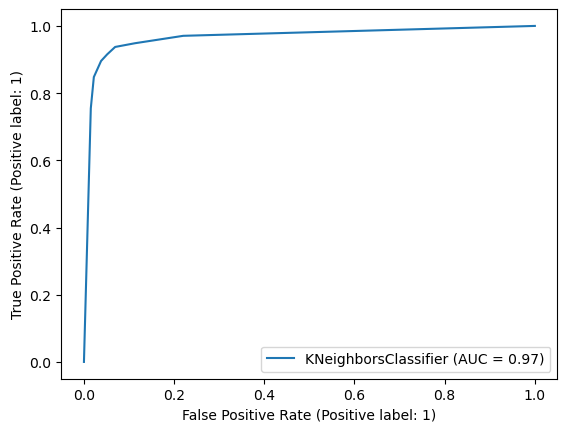

In [103]:
from sklearn.metrics import RocCurveDisplay               # ROC-кривая
# Построим ROC-кривую на тестовой выборке
RocCurveDisplay.from_estimator(knn2, features_test_knn, target_test)
plt.show()
plt.close()

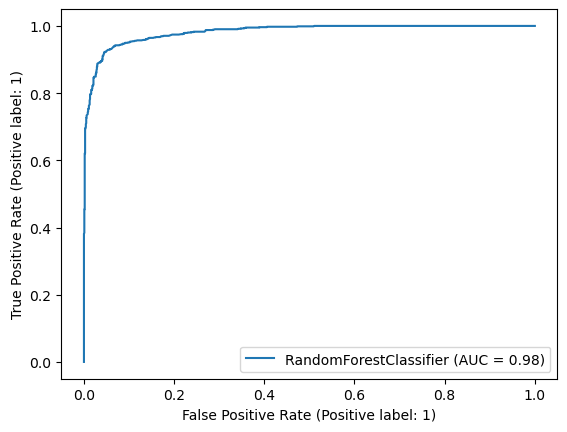

In [104]:
RocCurveDisplay.from_estimator(rf2, features_test, target_test)
plt.show()
plt.close()

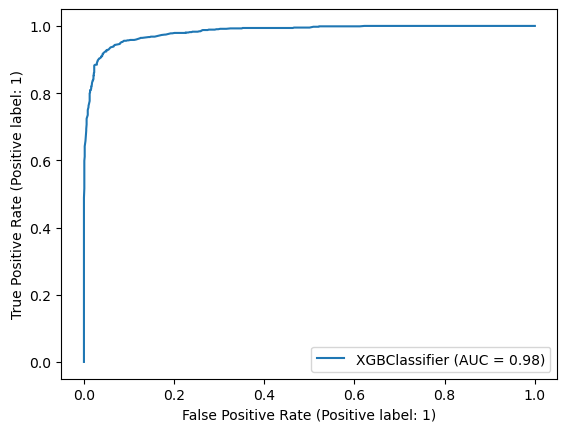

In [105]:
RocCurveDisplay.from_estimator(gb2, features_test, target_test)
plt.show()
plt.close()

По AUC однозначно выигрывают RF и XGBoost.

In [106]:
# Оценим вероятности на тестовой выборке
knn2_prob1  = knn2.predict_proba(features_test_knn)[:, 1]
rf2_prob1 = rf2.predict_proba(features_test)[:, 1]
gb2_prob1   = gb2.predict_proba(features_test)[:, 1]

In [107]:
# Сравним модели по AUC
from sklearn import metrics                               # метрики точности
rf2_AUC = metrics.roc_auc_score(target_test, rf2_prob1)
knn2_AUC = metrics.roc_auc_score(target_test, knn2_prob1)
gb2_AUC = metrics.roc_auc_score(target_test, gb2_prob1)
print(pd.DataFrame(data    = [rf2_AUC, knn2_AUC, gb2_AUC],
                   index   = ['rf2', 'knn2', 'gb2'],
                   columns = ['AUC']))

           AUC
rf2   0.981853
knn2  0.966239
gb2   0.982832


XGBoost немного лучше остальных методов.

Дополнительно: проделаем то же самое для Байесовской сети.

Структура байесовской сети определяется направленным ацикличным графом (DAG - directed acyclic graph). Поэтому, сперва необходимо сформировать DAG, указав предполагаемые направления причинно-следственных связей между переменными.

In [108]:
df_train = pd.concat([features_train, target_train], axis=1)
df_train.head()

,education,health,age,stress,sport_activities
0,8.0,0,40.0,0,0
1,13.0,0,50.0,0,0
2,6.0,0,80.0,0,0
3,18.0,0,28.0,0,0
4,4.0,0,24.0,0,0


In [109]:
!pip install bnlearn

In [110]:
# Подберем оптимальную структуру DAG на обучающей выборе
import bnlearn
bn2_train_structure = bnlearn.structure_learning.fit(df_train,
                                                     methodtype = 'hc',
                                                     scoretype  = 'aic')

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [aic]
[bnlearn] >Compute structure scores for model comparison (higher is better).


[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


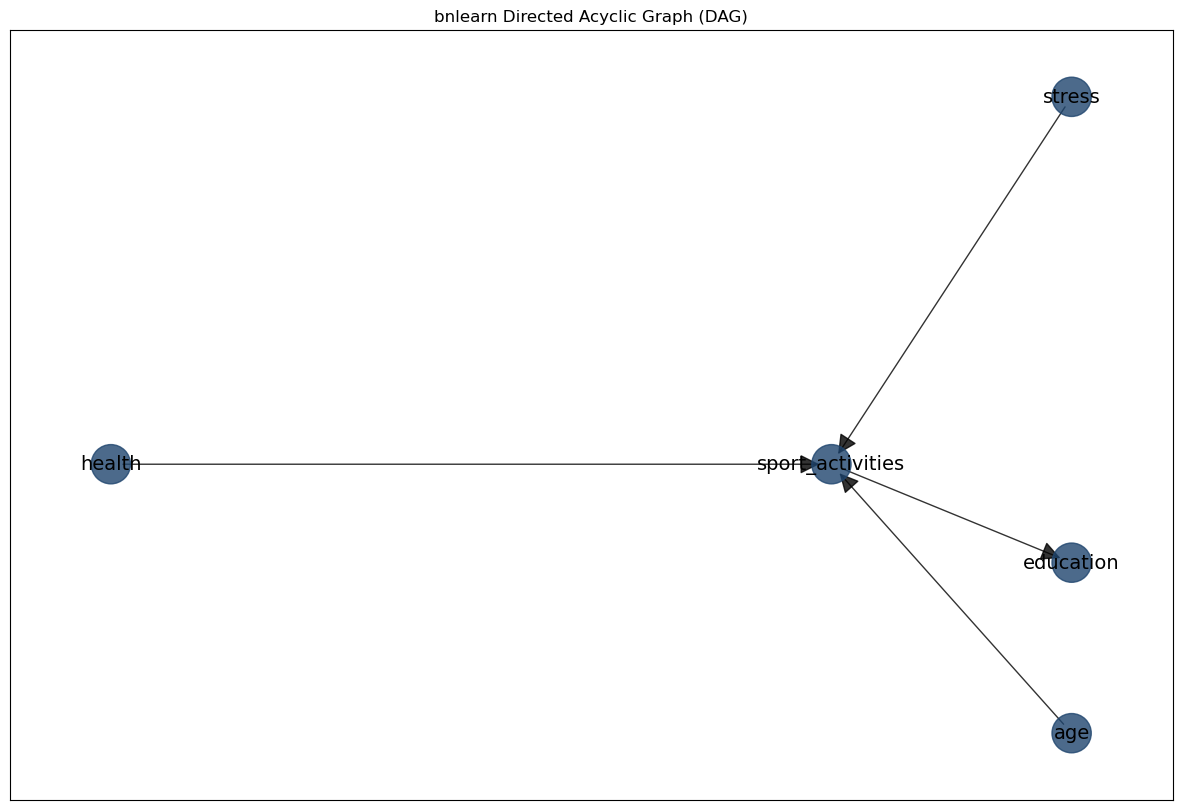

In [111]:
# Посмотрим на результат
bnlearn.plot(bn2_train_structure, interactive = False);

In [112]:
# Сохраним найденный DAG
DAG2 = bnlearn.make_DAG(bn2_train_structure)

[bnlearn] >No changes made to existing bayes DAG.


In [113]:
# Оценим модель с подобранным DAG
bn2_train = bnlearn.parameter_learning.fit(DAG2, df_train,
                                           methodtype = 'ml')

[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of health:
+-----------+---------+
| health(0) | 0.49275 |
+-----------+---------+
| health(1) | 0.50725 |
+-----------+---------+
[bnlearn] >CPD of sport_activities:
+---------------------+-----------+-----+-----------+-----------+
| age                 | age(14.0) | ... | age(80.0) | age(80.0) |
+---------------------+-----------+-----+-----------+-----------+
| health              | health(0) | ... | health(1) | health(1) |
+---------------------+-----------+-----+-----------+-----------+
| stress              | stress(0) | ... | stress(0) | stress(1) |
+---------------------+-----------+-----+-----------+-----------+
| sport_activities(0) | 1.0       | ... | 0.0       | 0.75      |
+---------------------+-----------+-----+-----------+-----------+
| sport_activities(1) | 0.0      

In [114]:
# Получим прогнозы по тестовой выборке
predict_bn2_test = bnlearn.predict(bn2_train, df = features_test,
                                   variables = ["sport_activities"])
prediction_bn2_test = np.array(predict_bn2_test.loc[:, "sport_activities"])

[bnlearn]> Remaining columns for inference: 4


100%|██████████| 1317/1317 [00:01<00:00, 1027.07it/s]


In [115]:
predict_bn2_test['p']

0       1.000000
1       0.955010
2       0.901323
3       1.000000
4       0.979299
          ...   
1995    0.979299
1996    0.659625
1997    0.979998
1998    1.000000
1999    0.785262
Name: p, Length: 2000, dtype: float64

In [116]:
bn_FPR, bn_TPR, bn_thresholds    = metrics.roc_curve(target_test, predict_bn2_test['p'])

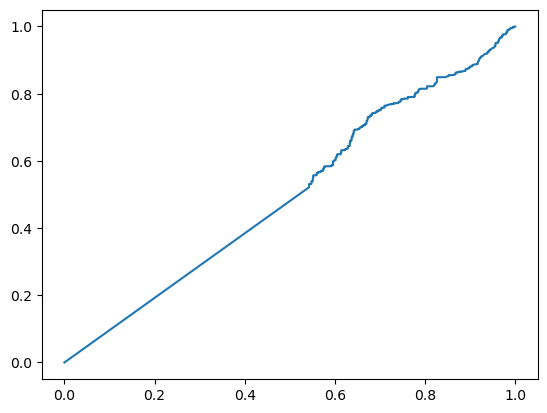

In [117]:
plt.plot(bn_FPR, bn_TPR, label = "bn")

In [118]:
bn_AUC = metrics.roc_auc_score(target_test, predict_bn2_test['p'])
bn_AUC

0.4999730786156195

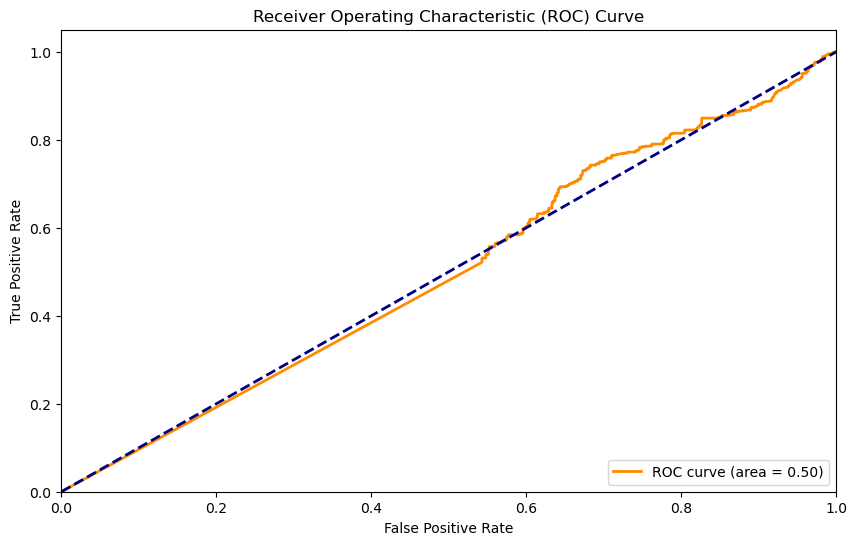

In [119]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(target_test, predict_bn2_test['p'])
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Скорее всего, автоматически подобраннный DAG неправильно описывает структуру зависимостей между переменными. Мы получили AUC сильно ниже, чем для других моделей, то есть BN почти не превосходит решения случайного выбора.

6. Постройте матрицу путаницы и предположите цены различных видов прогнозов. Исходя из критерия максимизации прибыли на обучающей выборке подберите оптимальный порог прогнозирования для каждого из методов и сравните
прибыли на тестовой выборке при соответствующих порогах. Результат представьте в форме таблицы, в которой должны быть указаны как AUC, так и
прибыли (на тестовой выборке). Проинтерпретируйте полученный результат.

Случайный лес.

In [120]:
from sklearn.metrics import confusion_matrix              # подсчет прогнозов

In [121]:
rf2_classes = rf2.predict(features_test)
rf2_classes

array([0, 1, 0, ..., 0, 0, 0])

In [122]:
TN, FP, FN, TP = confusion_matrix(target_test, rf2_classes).ravel()
# сохраним результат
predictions_rf2 = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
print(predictions_rf2)

TP     752
TN    1131
FP      54
FN      63
dtype: int64


 *предположим, у меня есть классификатор, которы выдает прогнозы TP, TN, FP, FN. я хочу присвоить цены этим прогнозам с точки зрения бизнеса или государства. я прогнозирую факт занятий спортом (0 или 1) с помощью переменных: здоровье, возраст, стресс и образование. придумай сюжет, то есть бизнес задачу, которая с помощью численного обоснования предложит цены для прогнозов.*

Сюжет: Оценка воздействия спортивных программ на здоровье населения

Контекст:
Городская администрация разработала программу по поощрению занятий спортом среди населения, чтобы улучшить общее состояние здоровья граждан. Программа включает различные мероприятия, такие как бесплатные занятия фитнесом, постройка спортивных площадок и информационные кампании. Администрация хочет оценить эффективность этой программы, прогнозируя, кто из граждан будет заниматься спортом на основе переменных: здоровье, возраст, стресс и образование.

Бизнес задача:
Оценка точности и ценности прогнозов о занятиях спортом поможет администрации эффективно распределить ресурсы и максимизировать положительный эффект программы на здоровье населения.

Численное обоснование и цены для прогнозов
1. True Positive (TP):
Когда модель правильно предсказывает, что человек будет заниматься спортом.

Бизнес значение: Такие люди будут улучшать свое здоровье, снижать нагрузку на медицинскую систему.
Цена: $500 - Это включает в себя экономию на медицинских расходах (предотвращение заболеваний), а также увеличение производительности труда за счет улучшенного здоровья.
2. True Negative (TN):
Когда модель правильно предсказывает, что человек не будет заниматься спортом.

Бизнес значение: Это помогает избежать необоснованных затрат на спортивные мероприятия для тех, кто не будет участвовать.
Цена: $100 - Это экономия на затратах, связанных с предоставлением спортивных мероприятий, которые не будут востребованы.
3. False Positive (FP):
Когда модель ошибочно предсказывает, что человек будет заниматься спортом.

Бизнес значение: Ресурсы будут затрачены впустую на человека, который не будет заниматься спортом.
Цена: -$200 - Это потерянные инвестиции в спортивные мероприятия и пропаганду, которые не принесут ожидаемых результатов.
4. False Negative (FN):
Когда модель ошибочно предсказывает, что человек не будет заниматься спортом.

Бизнес значение: Потенциально активные граждане не получат нужного внимания и ресурсов, что приводит к упущенной возможности улучшения здоровья населения.
Цена: -$300 - Это упущенная возможность улучшения здоровья граждан, что может привести к дополнительным медицинским расходам и потерям в производительности труда.

In [123]:
# Цены прогнозов
prices = pd.Series([5, 1, -2, -3], index = ["TP", "TN", "FP", "FN"])

In [124]:
# Оценим внутривыборочную прибыль от прогнозов
profit_rf2 = np.sum(prices * predictions_rf2)
print(profit_rf2)

4594


In [125]:
# Оценим условные вероятности на обучающей выборке
prob_rf2_train = rf2.predict_proba(features_train)[:, 1]

# Возможные значения порогов
thresholds_rf2 = np.unique(np.sort(prob_rf2_train))
print(thresholds_rf2)

[0.00000000e+00 2.44379277e-05 3.93081761e-05 ... 9.99947917e-01
 9.99955169e-01 1.00000000e+00]


In [126]:
# Число порогов
n_threshold_rf2 = thresholds_rf2.size

# Вектор для сохранения прибылей при различных порогах
profits_rf2 = np.zeros(n_threshold_rf2)

# Векторы различных видо прогнозов
TP_vec = np.zeros(n_threshold_rf2)
TN_vec = np.zeros(n_threshold_rf2)
FP_vec = np.zeros(n_threshold_rf2)
FN_vec = np.zeros(n_threshold_rf2)

In [127]:
# Рассчитаем прибыли для различных порогов
for i in range(0, n_threshold_rf2):
  # получаем прогнозы (на обучающей выборке) при соответствующем пороге
  prediction_rf_i = (prob_rf2_train >= thresholds_rf2[i]).astype(int)
  # считаем количество прогнозов различного вида
  TN_vec[i], FP_vec[i], FN_vec[i], TP_vec[i] = confusion_matrix(
    target_train, prediction_rf_i).ravel()
  # аггрегируем результаты прогнозов
  predictions_rf_i = pd.Series([TP_vec[i], TN_vec[i], FP_vec[i], FN_vec[i]],
                                index = ["TP", "TN", "FP", "FN"])
  # считаем прибыль
  profits_rf2[i] = np.sum(prices * predictions_rf_i)

In [128]:
# Достанем оптимальный порог
threshold_rf2 = thresholds_rf2[np.argmax(profits_rf2)]
print(threshold_rf2)

0.2142766789989486


In [129]:
# Посчитаем прибыль на тестовой выборке, используя порог
  # оценим условные вероятности на тестовой выборке
prob_rf2_test = rf2.predict_proba(features_test)[:, 1]
  # получим прогнозы на тестовой выборке
prediction_rf2 = prob_rf2_test >= threshold_rf2
  # посчитаем число прогнозов различного вида
TN, FP, FN, TP = confusion_matrix(target_test, prediction_rf2).ravel()
predictions_rf2 = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
  # оценим прибыль на тестовой выборке
profit_rf2_test_lin = np.sum(prices * predictions_rf2)
profit_rf2_test_lin

4587

Градиентный бустинг.

In [130]:
gb2_classes = gb2.predict(features_test)
gb2_classes

array([0, 1, 0, ..., 0, 0, 0])

In [131]:
TN, FP, FN, TP = confusion_matrix(target_test, gb2_classes).ravel()
# сохраним результат
predictions_gb2 = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
print(predictions_gb2)

TP     747
TN    1135
FP      50
FN      68
dtype: int64


In [132]:
# Оценим внутривыборочную прибыль от прогнозов
profit_gb2 = np.sum(prices * predictions_gb2)
print(profit_gb2)

4566


In [133]:
# Оценим условные вероятности на обучающей выборке
prob_gb2_train = gb2.predict_proba(features_train)[:, 1]

# Возможные значения порогов
thresholds_gb2 = np.unique(np.sort(prob_gb2_train))

# Число порогов
n_threshold_gb2 = thresholds_gb2.size
profits_gb2 = np.zeros(n_threshold_gb2)
TP_vec = np.zeros(n_threshold_gb2)
TN_vec = np.zeros(n_threshold_gb2)
FP_vec = np.zeros(n_threshold_gb2)
FN_vec = np.zeros(n_threshold_gb2)

In [134]:
# Рассчитаем прибыли для различных порогов
for i in range(0, n_threshold_gb2):
  # получаем прогнозы (на обучающей выборке) при соответствующем пороге
  prediction_gb_i = (prob_gb2_train >= thresholds_gb2[i]).astype(int)
  # считаем количество прогнозов различного вида
  TN_vec[i], FP_vec[i], FN_vec[i], TP_vec[i] = confusion_matrix(
    target_train, prediction_gb_i).ravel()
  # аггрегируем результаты прогнозов
  predictions_gb_i = pd.Series([TP_vec[i], TN_vec[i], FP_vec[i], FN_vec[i]],
                                index = ["TP", "TN", "FP", "FN"])
  # считаем прибыль
  profits_gb2[i] = np.sum(prices * predictions_gb_i)

In [135]:
# Достанем оптимальный порог
threshold_gb2 = thresholds_gb2[np.argmax(profits_gb2)]
print(threshold_gb2)

0.27745375


In [136]:
# Посчитаем прибыль на тестовой выборке, используя порог
  # оценим условные вероятности на тестовой выборке
prob_gb2_test = gb2.predict_proba(features_test)[:, 1]
  # получим прогнозы на тестовой выборке
prediction_gb2 = prob_gb2_test >= threshold_gb2
  # посчитаем число прогнозов различного вида
TN, FP, FN, TP = confusion_matrix(target_test, prediction_gb2).ravel()
predictions_gb2 = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
  # оценим прибыль на тестовой выборке
profit_gb2_test_lin = np.sum(prices * predictions_gb2)
profit_gb2_test_lin

4646

KNN.

In [137]:
# Получим прогнозы на тестовой выборке с помощью модели
# с подобранными значениями гиперпараметров
prediction_test_knn2 = knn2.predict(features_test_knn)

# Рассмотрим прогнозы различного вида
  # автоматически
TN, FP, FN, TP = confusion_matrix(target_test, prediction_test_knn2).ravel()

  # сохраним результат
predictions_knn2 = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
print(predictions_knn2)

TP     746
TN    1124
FP      61
FN      69
dtype: int64


In [138]:
# Оценим внутривыборочную прибыль от прогнозов
profit_knn2 = np.sum(prices * predictions_knn2)
print(profit_knn2)

4525


In [139]:
# Оценим условные вероятности на обучающей выборке
prob_knn2_train = knn2.predict_proba(features_train_knn)[:, 1]

# Возможные значения порогов
thresholds_knn2 = np.unique(np.sort(prob_knn2_train))
print(thresholds_knn2)

# Число порогов
n_threshold_knn2 = thresholds_knn2.size

# Вектор для сохранения прибылей при различных порогах
profits_knn2 = np.zeros(n_threshold_knn2)

# Векторы различных видо прогнозов
TP_vec = np.zeros(n_threshold_knn2)
TN_vec = np.zeros(n_threshold_knn2)
FP_vec = np.zeros(n_threshold_knn2)
FN_vec = np.zeros(n_threshold_knn2)

[0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.        ]


In [140]:
# Рассчитаем прибыли для различных порогов
for i in range(0, n_threshold_knn2):
  # получаем прогнозы (на обучающей выборке) при соответствующем пороге
  prediction_knn_i = (prob_knn2_train >= thresholds_knn2[i]).astype(int)
  # считаем количество прогнозов различного вида
  TN_vec[i], FP_vec[i], FN_vec[i], TP_vec[i] = confusion_matrix(
    target_train, prediction_knn_i).ravel()
  # аггрегируем результаты прогнозов
  predictions_knn_i = pd.Series([TP_vec[i], TN_vec[i], FP_vec[i], FN_vec[i]],
                                index = ["TP", "TN", "FP", "FN"])
  # считаем прибыль
  profits_knn2[i] = np.sum(prices * predictions_knn_i)

In [141]:
# Достанем оптимальный порог
threshold_knn2 = thresholds_knn2[np.argmax(profits_knn2)]
print(threshold_knn2)

0.2857142857142857


In [142]:
# Посчитаем прибыль на тестовой выборке, используя порог
  # оценим условные вероятности на тестовой выборке
prob_knn2_test = knn2.predict_proba(features_test_knn)[:, 1]
  # получим прогнозы на тестовой выборке
prediction_knn2 = prob_knn2_test >= threshold_knn2
  # посчитаем число прогнозов различного вида
TN, FP, FN, TP = confusion_matrix(target_test, prediction_knn2).ravel()
predictions_knn2 = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
  # оценим прибыль на тестовой выборке
profit_knn2_test_lin = np.sum(prices * predictions_knn2)
profit_knn2_test_lin

4522

Запишем результаты в таблицу.

In [143]:
data = {
    'Method': ['RF', 'XGB', 'KNN'],
    'AUC Score': [rf2_AUC, gb2_AUC, knn2_AUC],
    'Profit': [profit_rf2_test_lin, profit_gb2_test_lin, profit_knn2_test_lin]
}

df_metrics = pd.DataFrame(data)
df_metrics

,Method,AUC Score,Profit
0,RF,0.981853,4587
1,XGB,0.982832,4646
2,KNN,0.966239,4522


Заметим, что AUC может служать прокси для прибыли, когда мы не знаем цены, но все равно хотим сравнить модели.

Предложим другую функцию прибыли. Государство сильно потеряет в доверии избирателей, если они увидят пустующие спорт. площадки, на которые вообще-то были потрачены их деньги. Это будет очевидная трата ресурсов впустую, поэтому введём штраф за большие отклонения FP от 0.

In [144]:
def calculate_profit(tp, tn, fp, fn):
    profit = tp * prices['TP'] + tn * prices['TN'] + fp * prices['FP']
    profit += (fn ** 2) * prices['FN']
    return profit

In [145]:
# Оценим внутривыборочную прибыль от прогнозов
profit_rf2 = calculate_profit(predictions_rf2[0], predictions_rf2[1], predictions_rf2[2], predictions_rf2[3])
print(profit_rf2)

369


In [146]:
# Вектор для сохранения прибылей при различных порогах
profits_rf2 = np.zeros(n_threshold_rf2)

# Векторы различных видо прогнозов
TP_vec = np.zeros(n_threshold_rf2)
TN_vec = np.zeros(n_threshold_rf2)
FP_vec = np.zeros(n_threshold_rf2)
FN_vec = np.zeros(n_threshold_rf2)

In [147]:
# Рассчитаем прибыли для различных порогов
for i in range(0, n_threshold_rf2):
  # получаем прогнозы (на обучающей выборке) при соответствующем пороге
  prediction_rf_i = (prob_rf2_train >= thresholds_rf2[i]).astype(int)
  # считаем количество прогнозов различного вида
  TN_vec[i], FP_vec[i], FN_vec[i], TP_vec[i] = confusion_matrix(
    target_train, prediction_rf_i).ravel()
  # аггрегируем результаты прогнозов
  predictions_rf_i = pd.Series([TP_vec[i], TN_vec[i], FP_vec[i], FN_vec[i]],
                                index = ["TP", "TN", "FP", "FN"])
  # считаем прибыль
  profits_rf2[i] = calculate_profit(predictions_rf_i[0], predictions_rf_i[1], predictions_rf_i[2], predictions_rf_i[3])

In [148]:
# Достанем оптимальный порог
threshold_rf2 = thresholds_rf2[np.argmax(profits_rf2)]
print(threshold_rf2)

0.09173444140342964


Порог сдвинулся в сторону 0. Это логично, ведь наша модель теперь очень боится выдавать FN, и будет их избегать. Значит, есть стимулы как можно больше вхождений классифицировать как 1, и порог сдвинется к 0.

In [149]:
prob_rf2_test = rf2.predict_proba(features_test)[:, 1]
  # получим прогнозы на тестовой выборке
prediction_rf2 = prob_rf2_test >= threshold_rf2
  # посчитаем число прогнозов различного вида
TN, FP, FN, TP = confusion_matrix(target_test, prediction_rf2).ravel()
predictions_rf2 = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
  # оценим прибыль на тестовой выборке
profit_rf2_test = calculate_profit(predictions_rf2[0], predictions_rf2[1], predictions_rf2[2], predictions_rf2[3])
profit_rf2_test

3133

Градиентный бустинг.

In [150]:
# Оценим внутривыборочную прибыль от прогнозов
profit_gb2 = calculate_profit(predictions_gb2[0], predictions_gb2[1], predictions_gb2[2], predictions_gb2[3])
print(profit_gb2)

-1564


In [151]:
# Число порогов
n_threshold_gb2 = thresholds_gb2.size
profits_gb2 = np.zeros(n_threshold_gb2)
TP_vec = np.zeros(n_threshold_gb2)
TN_vec = np.zeros(n_threshold_gb2)
FP_vec = np.zeros(n_threshold_gb2)
FN_vec = np.zeros(n_threshold_gb2)

In [152]:
# Рассчитаем прибыли для различных порогов
for i in range(0, n_threshold_gb2):
  prediction_gb_i = (prob_gb2_train >= thresholds_gb2[i]).astype(int)
  TN_vec[i], FP_vec[i], FN_vec[i], TP_vec[i] = confusion_matrix(
    target_train, prediction_gb_i).ravel()
  predictions_gb_i = pd.Series([TP_vec[i], TN_vec[i], FP_vec[i], FN_vec[i]],
                                index = ["TP", "TN", "FP", "FN"])
  profits_gb2[i] = calculate_profit(predictions_gb_i[0], predictions_gb_i[1], predictions_gb_i[2], predictions_gb_i[3])

In [153]:
# Достанем оптимальный порог
threshold_gb2 = thresholds_gb2[np.argmax(profits_gb2)]
print(threshold_gb2)

0.05174363


In [154]:
prob_gb2_test = gb2.predict_proba(features_test)[:, 1]
prediction_gb2 = prob_gb2_test >= threshold_gb2
TN, FP, FN, TP = confusion_matrix(target_test, prediction_gb2).ravel()
predictions_gb2 = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
profit_gb2_test = calculate_profit(predictions_gb2[0], predictions_gb2[1], predictions_gb2[2], predictions_gb2[3])
profit_gb2_test

4007

KNN.

In [155]:
# Оценим внутривыборочную прибыль от прогнозов
profit_knn2 = calculate_profit(predictions_knn2[0], predictions_knn2[1], predictions_knn2[2], predictions_knn2[3])
print(profit_knn2)

-644


In [156]:
# Вектор для сохранения прибылей при различных порогах
profits_knn2 = np.zeros(n_threshold_knn2)

# Векторы различных видо прогнозов
TP_vec = np.zeros(n_threshold_knn2)
TN_vec = np.zeros(n_threshold_knn2)
FP_vec = np.zeros(n_threshold_knn2)
FN_vec = np.zeros(n_threshold_knn2)

In [157]:
# Рассчитаем прибыли для различных порогов
for i in range(0, n_threshold_knn2):
  # получаем прогнозы (на обучающей выборке) при соответствующем пороге
  prediction_knn_i = (prob_knn2_train >= thresholds_knn2[i]).astype(int)
  # считаем количество прогнозов различного вида
  TN_vec[i], FP_vec[i], FN_vec[i], TP_vec[i] = confusion_matrix(
    target_train, prediction_knn_i).ravel()
  # аггрегируем результаты прогнозов
  predictions_knn_i = pd.Series([TP_vec[i], TN_vec[i], FP_vec[i], FN_vec[i]],
                                index = ["TP", "TN", "FP", "FN"])
  # считаем прибыль
  profits_knn2[i] = calculate_profit(predictions_knn_i[0], predictions_knn_i[1], predictions_knn_i[2], predictions_knn_i[3])

In [158]:
# Достанем оптимальный порог
threshold_knn2 = thresholds_knn2[np.argmax(profits_knn2)]
print(threshold_knn2)

0.14285714285714285


In [159]:
# Посчитаем прибыль на тестовой выборке, используя порог
  # оценим условные вероятности на тестовой выборке
prob_knn2_test = knn2.predict_proba(features_test_knn)[:, 1]
  # получим прогнозы на тестовой выборке
prediction_knn2 = prob_knn2_test >= threshold_knn2
  # посчитаем число прогнозов различного вида
TN, FP, FN, TP = confusion_matrix(target_test, prediction_knn2).ravel()
predictions_knn2 = pd.Series([TP, TN, FP, FN], index = ["TP", "TN", "FP", "FN"])
  # оценим прибыль на тестовой выборке
profit_knn2_test = calculate_profit(predictions_knn2[0], predictions_knn2[1], predictions_knn2[2], predictions_knn2[3])
profit_knn2_test

2629

Запишем результаты в таблицу.

In [160]:
data = {
    'Method': ['RF', 'XGB', 'KNN'],
    'AUC Score': [rf2_AUC, gb2_AUC, knn2_AUC],
    'Profit linear': [profit_rf2_test_lin, profit_gb2_test_lin, profit_knn2_test_lin],
    'Profit monlinear': [profit_rf2_test, profit_gb2_test, profit_knn2_test]
}

df_metrics = pd.DataFrame(data)
df_metrics

,Method,AUC Score,Profit linear,Profit monlinear
0,RF,0.981853,4587,3133
1,XGB,0.982832,4646,4007
2,KNN,0.966239,4522,2629


В случае, когла мы сильно штрафуем за FN, пороги сдвигаются к 0. Лучший профит в случае нелинейной модели получаем в XGBoost оценивании.

7. Опишите предполагаемые связи между переменными в форме ориентированного ациклического графа (DAG). Обучите структуру Байесовской сети на обучающей выборке и сравните точность прогнозов вашего и обученного DAG на
тестовой выборке.


Обученный DAG уже получили выше. Попробуем самостоятельно описать структуру сети.

In [161]:
df_train

,education,health,age,stress,sport_activities
0,8.0,0,40.0,0,0
1,13.0,0,50.0,0,0
2,6.0,0,80.0,0,0
3,18.0,0,28.0,0,0
4,4.0,0,24.0,0,0
...,...,...,...,...,...
7995,4.0,0,76.0,0,0
7996,16.0,0,68.0,0,1
7997,8.0,0,52.0,0,0
7998,22.0,1,37.0,0,1


In [162]:
# Создадим DAG
edges = [("age", "education"),      # (откуда стрелочка, куда стрелочка)
         ("education", "stress"),
         ("age", "health"),
         ("health", "stress"),
         ("stress", "sport_activities"),
         ("health", "sport_activities")]

DAG0 = bnlearn.make_DAG(edges)

[bnlearn] >bayes DAG created.


Предлагаемая структура DAG

**Возраст → Образование:**

Возраст влияет на образование, так как по мере взросления люди обычно проходят через различные уровни образовательных учреждений, от начальной школы до высших учебных заведений.

**Образование → Стресс:**

Образование может влиять на уровень стресса. Более высокие образовательные требования могут приводить к увеличению стресса, в то время как лучшее образование может дать навыки для управления стрессом.

**Возраст → Здоровье:**

Возраст напрямую влияет на здоровье, так как с возрастом здоровье обычно меняется. Пожилые люди могут сталкиваться с большими проблемами со здоровьем по сравнению с молодыми.

**Здоровье → Стресс:**

Состояние здоровья значительно влияет на уровень стресса. Плохое здоровье может приводить к большему стрессу из-за физического дискомфорта и беспокойства о благополучии.

**Стресс → Занятия спортом:**

Уровень стресса может влиять на вероятность занятия спортом. Высокий стресс может снижать участие в спорте, в то время как некоторые люди могут использовать спорт для снижения стресса.

**Здоровье → Занятия спортом:**

Здоровье влияет на способность и мотивацию заниматься спортом. Хорошее здоровье обычно способствует более активному участию в спортивных мероприятиях.

In [163]:
# Оценим факторы
bn0 = bnlearn.parameter_learning.fit(DAG0, df_train, methodtype = 'ml')

[bnlearn] >Parameter learning> Computing parameters using [ml]
[bnlearn] >CPD of age:
+-----------+----------+
| age(14.0) | 0.11375  |
+-----------+----------+
| age(15.0) | 0.009    |
+-----------+----------+
| age(16.0) | 0.008625 |
+-----------+----------+
| age(17.0) | 0.0105   |
+-----------+----------+
| age(18.0) | 0.009875 |
+-----------+----------+
| age(19.0) | 0.011625 |
+-----------+----------+
| age(20.0) | 0.0075   |
+-----------+----------+
| age(21.0) | 0.009125 |
+-----------+----------+
| age(22.0) | 0.00875  |
+-----------+----------+
| age(23.0) | 0.012125 |
+-----------+----------+
| age(24.0) | 0.011875 |
+-----------+----------+
| age(25.0) | 0.012    |
+-----------+----------+
| age(26.0) | 0.011625 |
+-----------+----------+
| age(27.0) | 0.011875 |
+-----------+----------+
| age(28.0) | 0.012625 |
+-----------+----------+
| age(29.0) | 0.01325  |
+-----------+----------+
| age(30.0) | 0.012    |
+-----------+----------+
| age(31.0) | 0.014875 |
+-----------+-

[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


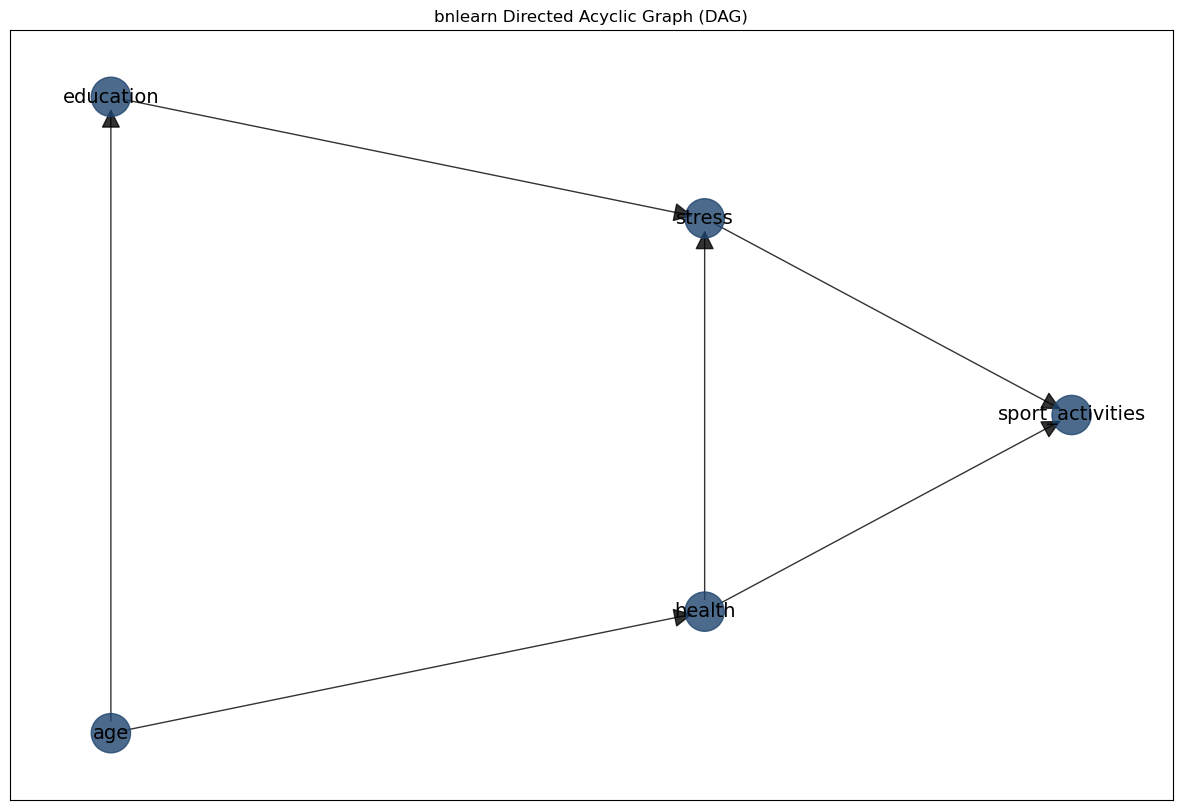

In [164]:
# Визуализируем DAG
bnlearn.plot(bn0, interactive = False);

In [165]:
predict_bn0 = bnlearn.predict(bn0, df = features_test, variables = ["sport_activities"])

[bnlearn]> Remaining columns for inference: 4


100%|██████████| 1317/1317 [00:01<00:00, 1094.94it/s]


In [166]:
prediction_bn_test0 = np.array(predict_bn0.loc[:, "sport_activities"])

In [167]:
ACC_bn_test0 = np.mean(target_test == prediction_bn_test0)
ACC_bn_test0

0.899

In [168]:
ACC_bn_test_fit = np.mean(target_test == prediction_bn2_test) # из модели выше
ACC_bn_test_fit

0.936

Точность нашего DAG достаточно высокая, но она несколько уступает точности DAG с обученной структурой.

8. На основании проделанного анализа выберите лучший и худший из обученных классификаторов. Обоснуйте сделанный выбор.

Мы обучили случайный лес, градиентный бустинг и метод ближайших соседей + дополнительно построили классификатор на основании байесовских сетей. Первые три классификатора мы можем сравнить не только по точности и AUC, но и по прибылям и дополнительным метрикам качества. По точности, f1-мере и сбалансирвоанной метрике 'точность/f1-мера' XGBoost показывал качество не хуже двух дпугих моделей, тогда как KNN -- не лучше двух других моделей, как на оценке на тестовой выборке, так и на оценке с помощью CV. Подбор гиперпараметров обычно немного ухудшал качество случайного леса, почти не улучшал качетво XGBoost, но немного улучшал качество KNN. Тем не менее, исходя только из перечисленных мтерик качества, XGBoost оказывался лучшим классификатором, а KNN худшим.

При оптимальном пороге XGBoost также позволял получить наибольшую прибыль как в линейном, так и в нелинейном случае записи функции. KNN показывал наименьшую прибыль в обоих случаях. По AUC XGBoost тоже опережает другие модели, а KNN справляется немного хуже.

Вывод: лучшим классификатором стоит признать XGBoost с подобранными гиперпараметрами, худшим -- KNN. Байесовские сети показывали точность на тестовой выборке не лучше KNN.

9. Повышенная сложность: включите в анализ дополнительный метод классификации, не рассматривавшийся в курсе и не представленный в библиотеке
scikit-learn. Опишите данный метод (принцип работы, преимущества и недостатки) и осуществите тюнинг гиперпараметров. Сопоставьте его точность на
тестовой выборке с точностью лучшего из обученных вами ранее методов.

# Регрессия.

1. Отберите признаки, которые могут быть полезны при прогнозировании целевой (зависимой) переменной. Не включайте в число этих признаков переменную
воздействия.


Будем использовать следующие методы: случайный лес, градиентный бустинг и KNN.

Целевая переменная: заработная плата индивида. Переменныую воздействия опустим. Полезные признаки при прогнозировании заработной платы: образование, здоровье, возраст, стресс. Способности также были бы полезны, но обычно мы их не наблюдаем.

In [169]:
df.head()

,sport_activities,education,health,age,stress,abilities,GYM_distance,wage
0,1,4.0,1,37.0,0,14.0,1,52.314629
1,1,17.0,1,50.0,0,1.0,1,74.630682
2,0,13.0,0,42.0,0,1.0,0,23.842901
3,0,4.0,0,79.0,0,35.0,0,43.376869
4,1,8.0,1,44.0,0,23.0,1,63.034816


2. Выберите произвольные значения гиперпараметров, а затем оцените и сравните
(между методами) точность прогнозов с помощью RMSE и MAPE:

• на обучающей выборке.
• на тестовой выборке.
• с помощью кросс-валидации (используйте только обучающую выборку)

Начнём со случайного леса.

In [170]:
from sklearn.model_selection import train_test_split

# Разделим целевую переменную и признаки
target = df.loc[:, ['wage']]                    # целевая переменная
features = df.loc[:, df.columns.drop(['wage', 'GYM_distance', 'abilities', 'sport_activities'])]    # матрица признаков
target = np.squeeze(target)                     # преобразуем из вектора столбца
                                                # в одномерный массив
# Разделим выборку на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.2, random_state = 777)

# Сохраним число наблюдений обучающей и тестовой выборок
n_train = len(target_train)
n_test  = len(target_test)

# Вернем исходную сортировку индексов
features_train = features_train.reset_index(drop = True)
target_train   = target_train.reset_index(drop = True)
features_test  = features_test.reset_index(drop = True)
target_test    = target_test.reset_index(drop = True)

In [171]:
!pip install -U scikit-learn

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB 445.2 kB/s eta 0:00:25
   ---------------------------------------- 0.1/11.0 MB 550.5 kB/s eta 0:00:20
   ---------------------------------------- 0.1/11.0 MB 590.8 kB/s eta 0:00:19
    --------------------------------------- 0.2/11.0 MB 807.1 kB/s eta 0:00:14
    --------------------------------------- 0.2/11.0 MB 901.1 kB/s eta 0:00:12
   - -------------------------------------- 0.3/11.0 MB 983.9 kB/s eta 0:00:11
   - -------------------------------------- 0.3/11.0 MB 985.2 kB/s eta 0:00:11
   - -------------------------------------- 0.4/11.0 MB 971.5 kB/s eta 0:00:11
   - -------------------------------------- 0.4/11.0 MB 960.7 kB/s eta 0:00:11
   - -------------------------------------- 0.4/11.0 MB 960.7 kB/s eta 0:00:11
   - -------------------------------------- 0.4/11.0 MB 960.7 kB/s eta

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.


In [172]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import sklearn

Начнём со случайного леса.

In [173]:
# Обучим случайный лес
rf_reg = RandomForestRegressor(max_depth = 12,         # максимальная глубина деревьев
                            max_features = "sqrt",  # число случайно выбираемых при
                                                    # каждом разбиении признаков
                            max_samples = 500,      # число бутстрап итераций
                            random_state = 777,     # для вопроизводимости
                            criterion = 'friedman_mse')  # критерий выбора признаков
                                                    # при разбиении узлов
rf_reg.fit(features_train, target_train)

RandomForestRegressor(criterion='friedman_mse', max_depth=12,
                      max_features='sqrt', max_samples=500, random_state=777)

In [174]:
!pip install permetrics

In [175]:
from permetrics import RegressionMetric

In [176]:
rf_pred = rf_reg.predict(features_train)

evaluator = RegressionMetric(list(target_train), rf_pred)
results_rf_train = evaluator.get_metrics_by_list_names(["RMSE","MAPE"])
print(results_rf_train["RMSE"])
print(results_rf_train["MAPE"])

14.099212884840874
0.2161968675547244


In [177]:
rf_pred = rf_reg.predict(features_test)

evaluator = RegressionMetric(list(target_test), rf_pred)
results_rf_test = evaluator.get_metrics_by_list_names(["RMSE","MAPE"])
print(results_rf_test["RMSE"])
print(results_rf_test["MAPE"])

14.857242240360858
0.22694356024053608


In [178]:
from sklearn.model_selection import cross_val_score

In [179]:
#  с помощью кросс-валидации
rmse_CV_rf = cross_val_score(estimator = rf_reg,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_root_mean_squared_error')             # количество частей (folds)
rmse_CV_total_rf = -np.mean(rmse_CV_rf)            # средняя точность по фолдам
print(rmse_CV_total_rf)

#  с помощью кросс-валидации
mape_CV_rf = cross_val_score(estimator = rf_reg,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_mean_absolute_percentage_error')             # количество частей (folds)
mape_CV_total_rf = -np.mean(mape_CV_rf)            # средняя точность по фолдам
print(mape_CV_total_rf)

14.774895876458547
0.22623094011420403


XGBoost.

In [180]:
from xgboost import XGBRegressor                        # продвинутый бустинг
from sklearn.model_selection import GridSearchCV          # подбор гиперпараметров

In [181]:
# Обучим модель
gb_reg = XGBRegressor(n_estimators = 50,
                    max_depth = 3,
                    learning_rate = 0.5,
                    reg_lambda = 0.01,
                    random_state = 123)
gb_reg.fit(features_train, target_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [182]:
gb_pred = gb_reg.predict(features_train) # train

evaluator = RegressionMetric(list(target_train), gb_pred)
results_gb_train = evaluator.get_metrics_by_list_names(["RMSE","MAPE"])
print(results_gb_train["RMSE"])
print(results_gb_train["MAPE"])

gb_pred = gb_reg.predict(features_test) # test

evaluator = RegressionMetric(list(target_test), gb_pred)
results_gb_test = evaluator.get_metrics_by_list_names(["RMSE","MAPE"])
print(results_gb_test["RMSE"])
print(results_gb_test["MAPE"])

#  с помощью кросс-валидации
rmse_CV_gb = cross_val_score(estimator = gb_reg,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_root_mean_squared_error')             # количество частей (folds)
rmse_CV_total_gb = -np.mean(rmse_CV_gb)            # средняя точность по фолдам
print(rmse_CV_total_gb)

#  с помощью кросс-валидации
mape_CV_gb = cross_val_score(estimator = gb_reg,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_mean_absolute_percentage_error')             # количество частей (folds)
mape_CV_total_gb = -np.mean(mape_CV_gb)            # средняя точность по фолдам
print(mape_CV_total_gb)

14.262327987693588
0.21696257233173524
14.842554438786843
0.22329347125567875
14.816588055360715
0.22542671832111177


KNN.

In [183]:
from sklearn.neighbors import KNeighborsRegressor

In [185]:
# Сохраним данные до нормализации
features_train_initial = features_train.copy()
features_test_initial  = features_test.copy()

# Подготовим объект, осуществляющий нормализацию
scaler = sklearn.preprocessing.StandardScaler().fit(features_train)

# Нормализуем данные
features_train_knn = scaler.transform(features_train_initial)  # обучающая выборка
features_test_knn  = scaler.transform(features_test_initial)   # тестовая выборка

In [186]:

# Воспользуемся методом ближайших соседей
knn_reg = KNeighborsRegressor(n_neighbors = 40,      # число соседей
                           metric = "minkowski", # метрика расстояния
                           p = 2)
knn_reg.fit(features_train_knn, target_train)            # обучение на данных

KNeighborsRegressor(n_neighbors=40)

In [187]:
knn_pred = knn_reg.predict(features_train_knn) # train

evaluator = RegressionMetric(list(target_train), knn_pred)
results_knn_train = evaluator.get_metrics_by_list_names(["RMSE","MAPE"])
print(results_knn_train["RMSE"])
print(results_knn_train["MAPE"])

knn_pred = knn_reg.predict(features_test_knn) # test

evaluator = RegressionMetric(list(target_test), knn_pred)
results_knn_test = evaluator.get_metrics_by_list_names(["RMSE","MAPE"])
print(results_knn_test["RMSE"])
print(results_knn_test["MAPE"])

#  с помощью кросс-валидации
rmse_CV_knn = cross_val_score(estimator = knn_reg,     # модель
                            X = features_train_knn,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_root_mean_squared_error')             # количество частей (folds)
rmse_CV_total_knn = -np.mean(rmse_CV_knn)            # средняя точность по фолдам
print(rmse_CV_total_knn)

#  с помощью кросс-валидации
mape_CV_knn = cross_val_score(estimator = knn_reg,     # модель
                            X = features_train_knn,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_mean_absolute_percentage_error')             # количество частей (folds)
mape_CV_total_knn = -np.mean(mape_CV_knn)            # средняя точность по фолдам
print(mape_CV_total_knn)

14.432073301542808
0.21972179669193886
14.862880671642106
0.22440553141907862
14.795242603932214
0.22614302819793491


Результаты.

In [188]:
df_dict = [
    {'Model': 'KNN', 'Train_RMSE': results_knn_train["RMSE"], 'Train_MAPE': results_knn_train["MAPE"], 'Test_RMSE': results_knn_test["RMSE"], 'Test_MAPE': results_knn_test["MAPE"],
     'CV_RMSE': rmse_CV_total_knn, 'CV_MAPE': mape_CV_total_knn},
    {'Model': 'RF', 'Train_RMSE': results_rf_train["RMSE"], 'Train_MAPE': results_rf_train["MAPE"], 'Test_RMSE': results_rf_test["RMSE"], 'Test_MAPE': results_rf_test["MAPE"],
     'CV_RMSE': rmse_CV_total_rf, 'CV_MAPE': mape_CV_total_rf},
    {'Model': 'XGBoost', 'Train_RMSE': results_gb_train["RMSE"], 'Train_MAPE': results_gb_train["MAPE"], 'Test_RMSE': results_gb_test["RMSE"], 'Test_MAPE': results_gb_test["MAPE"],
     'CV_RMSE': rmse_CV_total_gb, 'CV_MAPE': mape_CV_total_gb},
]

# Convert dictionary to DataFrame
res_simple = pd.DataFrame(df_dict)
res_simple

,Model,Train_RMSE,Train_MAPE,Test_RMSE,Test_MAPE,CV_RMSE,CV_MAPE
0,KNN,14.432073,0.219722,14.862881,0.224406,14.795243,0.226143
1,RF,14.099213,0.216197,14.857242,0.226944,14.774896,0.226231
2,XGBoost,14.262328,0.216963,14.842554,0.223293,14.816588,0.225427


Все модели дают очень похожие результаты на тесте и CV, тогда как на трейне KNN чуть хуже.

3. Для каждого метода с помощью кросс-валидации на обучающей выборке подберите оптимальные значения гиперпараметров (тюнинг). В качестве критерия
качества используйте RMSE. Результат представьте в форме таблицы, в которой для каждого метода должны быть указаны:
• изначальные и подобранные значения гиперпараметров.
• кросс-валидационное значение RMSE на обучающей выборке с исходными
и подобранными значениями гиперпараметров.
• значение RMSE на тестовой выборке с исходными и подобранными значениями гиперпараметров.

In [189]:
# Гиперпараметры модели
rf_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'max_depth': 12,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': 500,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 777,
 'verbose': 0,
 'warm_start': False}

In [190]:
hyperparameters = {
    'n_estimators': [120, 70, 100],             # Number of trees in the forest
    'max_depth': [None, 10, 12, 15],            # Maximum depth of the tree
    'min_samples_split': [2, 5, 7],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],   # Number of features to consider when looking for the best split
}


In [191]:
# Перебор гиперпараметров с помощью кросс-валидации
GSCV_rf = GridSearchCV(estimator = rf_reg,               # модель
                        param_grid = hyperparameters,  # перебираемые гиперпараметры
                        scoring = "neg_root_mean_squared_error",          # метрика качества модели
                        cv = 5,
                       verbose = 1)                        # число фолдов в кросс-валидации
GSCV_rf.fit(features_train, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(criterion='friedman_mse',
                                             max_depth=12, max_features='sqrt',
                                             max_samples=500,
                                             random_state=777),
             param_grid={'max_depth': [None, 10, 12, 15],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [120, 70, 100]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [192]:
# Достанем гиперпараметры, соответствующие лучшей модели
hyperparameters_best_rf = GSCV_rf.best_params_
print(hyperparameters_best_rf)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 120}


In [193]:
# Create the model with the best hyperparameters
rf_reg2 = RandomForestRegressor(
    max_depth=hyperparameters_best_rf["max_depth"],
    max_features=hyperparameters_best_rf["max_features"],
    min_samples_leaf=hyperparameters_best_rf["min_samples_leaf"],
    min_samples_split=hyperparameters_best_rf["min_samples_split"],
    n_estimators=hyperparameters_best_rf["n_estimators"],
    random_state=777  # Ensure reproducibility
)

# Train the model
rf_reg2.fit(features_train, target_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=7, n_estimators=120, random_state=777)

In [194]:
rf_pred = rf_reg2.predict(features_test)

evaluator = RegressionMetric(list(target_test), rf_pred)
results_rf_test_tuned = evaluator.get_metrics_by_list_names(["RMSE","MAPE"])
print(results_rf_test_tuned["RMSE"])
print(results_rf_test_tuned["MAPE"])

14.860655873293707
0.22435146955854457


In [195]:
#  с помощью кросс-валидации
rmse_CV_rf = cross_val_score(estimator = rf_reg2,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_root_mean_squared_error')             # количество частей (folds)
rmse_CV_total_rf_tuned = -np.mean(rmse_CV_rf)            # средняя точность по фолдам
print(rmse_CV_total_rf_tuned)

#  с помощью кросс-валидации
mape_CV_rf = cross_val_score(estimator = rf_reg2,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_mean_absolute_percentage_error')             # количество частей (folds)
mape_CV_total_rf_tuned = -np.mean(mape_CV_rf)            # средняя точность по фолдам
print(mape_CV_total_rf_tuned)

14.858172525905871
0.22710827859545352


Тюнинг XGBoost

In [196]:
# Определим набор рассматриваемых гиперпараметров
hyperparameters_gb =  {'max_depth': [2, 3, 4, 10],
                    'learning_rate': [0.1, 0.5, 1],
                    'n_estimators': [20, 50, 100]}

# Применим кросс-валиадцию
GSCV_gb = GridSearchCV(estimator = gb_reg,               # модель
                        param_grid = hyperparameters_gb,  # перебираемые гиперпараметры
                        scoring = "neg_root_mean_squared_error",          # метрика качества модели
                        cv = 5,
                       verbose = 1)                        # число фолдов в кросс-валидации
GSCV_gb.fit(features_train, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.5, ma...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=3, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=50,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=123, ...),
             param_grid={'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [2, 3, 4, 10],
                         'n_estimators': [20, 50, 100]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [197]:
# Достанем гиперпараметры, соответствующие лучшей модели
hyperparameters_best_gb = GSCV_gb.best_params_
print(hyperparameters_best_gb)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}


In [198]:
# Обучим модель с лучшими гиперпараметрами
gb_reg2 = XGBRegressor(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    random_state = 123)
gb_reg2.fit(features_train, target_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [199]:
gb_pred = gb_reg2.predict(features_test) # test

evaluator = RegressionMetric(list(target_test), gb_pred)
results_gb_test_tuned = evaluator.get_metrics_by_list_names(["RMSE","MAPE"])
print(results_gb_test_tuned["RMSE"])
print(results_gb_test_tuned["MAPE"])

#  с помощью кросс-валидации
rmse_CV_gb = cross_val_score(estimator = gb_reg2,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_root_mean_squared_error')             # количество частей (folds)
rmse_CV_total_gb_tuned = -np.mean(rmse_CV_gb)            # средняя точность по фолдам
print(rmse_CV_total_gb_tuned)

#  с помощью кросс-валидации
mape_CV_gb = cross_val_score(estimator = gb_reg2,     # модель
                            X = features_train,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_mean_absolute_percentage_error')             # количество частей (folds)
mape_CV_total_gb_tuned = -np.mean(mape_CV_gb)            # средняя точность по фолдам
print(mape_CV_total_gb_tuned)

14.786598803535009
0.2238301704657572
14.683641226497418
0.22422817447305476


KNN.

In [200]:
# Перебираемые значения гиперпараметров
hyperparameters_knn = {'n_neighbors': [10, 20, 30, 40, 50], 'p': [1, 2, 3, 4]}

In [201]:
# Перебор гиперпараметров с помощью кросс-валидации
GSCV_knn = GridSearchCV(estimator = knn_reg,               # модель
                        param_grid = hyperparameters_knn,  # перебираемые гиперпараметры
                        scoring = "neg_root_mean_squared_error",          # метрика качества модели
                        cv = 5, verbose = 1)                        # число фолдов в кросс-валидации
GSCV_knn.fit(features_train_knn, target_train)             # подбор гиперпараметров
                                                       # на конкретных данных

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, estimator=KNeighborsRegressor(n_neighbors=40),
             param_grid={'n_neighbors': [10, 20, 30, 40, 50],
                         'p': [1, 2, 3, 4]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [202]:
hyperparameters_best_knn = GSCV_knn.best_params_

In [203]:
# Обучим модель с лучшими гиперпараметрами
knn_reg2 = KNeighborsRegressor(n_neighbors = hyperparameters_best_knn["n_neighbors"],
                            metric = "minkowski",
                            p = hyperparameters_best_knn["p"])
knn_reg2.fit(features_train_knn, target_train)

KNeighborsRegressor(n_neighbors=50, p=1)

In [204]:
knn_pred = knn_reg2.predict(features_test_knn) # test

evaluator = RegressionMetric(list(target_test), knn_pred)
results_knn_test_tuned = evaluator.get_metrics_by_list_names(["RMSE","MAPE"])
print(results_knn_test_tuned["RMSE"])
print(results_knn_test_tuned["MAPE"])

#  с помощью кросс-валидации
rmse_CV_knn = cross_val_score(estimator = knn_reg2,     # модель
                            X = features_train_knn,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_root_mean_squared_error')             # количество частей (folds)
rmse_CV_total_knn_tuned = -np.mean(rmse_CV_knn)            # средняя точность по фолдам
print(rmse_CV_total_knn_tuned)

#  с помощью кросс-валидации
mape_CV_knn = cross_val_score(estimator = knn_reg2,     # модель
                            X = features_train_knn,       # признаки
                            y = target_train,         # целевая переменная
                            cv = 5,
                            scoring = 'neg_mean_absolute_percentage_error')             # количество частей (folds)
mape_CV_total_knn_tuned = -np.mean(mape_CV_knn)            # средняя точность по фолдам
print(mape_CV_total_knn_tuned)

14.867942661292858
0.22464199534458346
14.743002505038671
0.22507615627930475


In [205]:
params_before = rf_reg.get_params()
params_after = rf_reg2.get_params()

# Create DataFrame for accuracies
metric_data = {
    'Metric/Feature': ['RMSE on Test Data', 'RMSE on CV Data', 'MAPE on Test Data', 'MAPE on CV Data',],
    'Before Tuning': [results_rf_test["RMSE"], rmse_CV_total_rf, results_rf_test["MAPE"], mape_CV_total_rf],
    'After Tuning': [results_rf_test_tuned["RMSE"], rmse_CV_total_rf_tuned, results_rf_test_tuned["MAPE"], mape_CV_total_rf_tuned]
}

metric_df = pd.DataFrame(metric_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([metric_df, params_df], ignore_index=True)
comparison_df.head(16)


,Metric/Feature,Before Tuning,After Tuning
0,RMSE on Test Data,14.857242,14.860656
1,RMSE on CV Data,14.774896,14.858173
2,MAPE on Test Data,0.226944,0.224351
3,MAPE on CV Data,0.226231,0.227108
4,bootstrap,True,True
5,ccp_alpha,0.0,0.0
6,criterion,friedman_mse,squared_error
7,max_depth,12,10
8,max_features,sqrt,sqrt
9,max_leaf_nodes,None,None


Модель с подобранными гиперпараметрами показывает лучшие результаты на тестовой выборке, но худшие при оценке по CV. Многие параметры модели изменились.

Результаты XGBoost

In [206]:
# Example variables (replace these with your actual data)
params_before = gb_reg.get_params()
params_after = gb_reg2.get_params()

# Create DataFrame for accuracies
metric_data = {
    'Metric/Feature': ['RMSE on Test Data', 'RMSE on CV Data', 'MAPE on Test Data', 'MAPE on CV Data',],
    'Before Tuning': [results_gb_test["RMSE"], rmse_CV_total_gb, results_gb_test["MAPE"], mape_CV_total_gb],
    'After Tuning': [results_gb_test_tuned["RMSE"], rmse_CV_total_gb_tuned, results_gb_test_tuned["MAPE"], mape_CV_total_gb_tuned]
}

metric_df = pd.DataFrame(metric_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([metric_df, params_df], ignore_index=True)
comparison_df.head(37)


,Metric/Feature,Before Tuning,After Tuning
0,RMSE on Test Data,14.842554,14.786599
1,RMSE on CV Data,14.816588,14.683641
2,MAPE on Test Data,0.223293,0.22383
3,MAPE on CV Data,0.225427,0.224228
4,objective,reg:squarederror,reg:squarederror
5,base_score,None,None
6,booster,None,None
7,callbacks,None,None
8,colsample_bylevel,None,None
9,colsample_bynode,None,None


Изменились некоторые опции параметров при переборе. При этом качество модели стало чуть лучше при оценке обоими способами и по обеим метрикам.

Результаты KNN.

In [207]:
# Example variables (replace these with your actual data)
params_before = knn_reg.get_params()
params_after = knn_reg2.get_params()

# Create DataFrame for accuracies
metric_data = {
    'Metric/Feature': ['RMSE on Test Data', 'RMSE on CV Data', 'MAPE on Test Data', 'MAPE on CV Data',],
    'Before Tuning': [results_knn_test["RMSE"], rmse_CV_total_knn, results_knn_test["MAPE"], mape_CV_total_knn],
    'After Tuning': [results_knn_test_tuned["RMSE"], rmse_CV_total_knn_tuned, results_knn_test_tuned["MAPE"], mape_CV_total_knn_tuned]
}

metric_df = pd.DataFrame(metric_data)

# Create DataFrame for parameters
params_data = {
    'Metric/Feature': list(params_before.keys()),
    'Before Tuning': list(params_before.values()),
    'After Tuning': list(params_after.values())
}

params_df = pd.DataFrame(params_data)
comparison_df = pd.concat([metric_df, params_df], ignore_index=True)
comparison_df.head(11)


,Metric/Feature,Before Tuning,After Tuning
0,RMSE on Test Data,14.862881,14.867943
1,RMSE on CV Data,14.795243,14.743003
2,MAPE on Test Data,0.224406,0.224642
3,MAPE on CV Data,0.226143,0.225076
4,algorithm,auto,auto
5,leaf_size,30,30
6,metric,minkowski,minkowski
7,metric_params,None,None
8,n_jobs,None,None
9,n_neighbors,40,50


Изменились некоторые пареметры при переборе. При этом качество модели почти не изменилось при оценке по обеим метрикам и обоими способами.

Повышенная сложность: подберите на обучающей выборке оптимальные
значения гиперпараметров градиентного бустинга ориентируясь на значение
OOB (out-of-bag) ошибки. Сопоставьте гиперпараметры и **RMSE** на тестовой выборке для градиентного бустинга в зависимости от того, используется
кросс-валидация или OOB ошибка.

4. На основании проделанного анализа выберите лучший и худший из обученных методов. Обоснуйте сделанный выбор.


In [208]:
print(min(results_rf_test_tuned["MAPE"], results_gb_test_tuned["MAPE"], results_knn_test_tuned["MAPE"]))
print(min(mape_CV_total_rf_tuned, mape_CV_total_gb_tuned, mape_CV_total_knn_tuned))

0.2238301704657572
0.22422817447305476


Будем сранивать модели после тюнинга по RMSE и MAPE. После тюнинга лучшее значение RMSE как на тестовой выборке, так и на оценке по CV мы получили для XGBoost, то есть это лучшая модель. То же верно и для MAPE.

Ошибки на тестовой выборке выше у KNN, но на кросс-валидации у RF. В целом кросс-валидация учитывает больше информации о всей выборке, поэтому будем ориентироваться на нее при решении, какой метод хуже. В таком случае, RF показывает худший результат.

**Вывод:** лучший метод это XGBoost, худший -- RF.

# OLS DML

**Оценивание отдачи от занятий спортом с помощью МНК** 🐱

Цели ⭐

*   Оценить отдачу от занятий спортом, то есть параметр $\alpha$, с пощью метода наименьших квадратов (МНК).

Рассмотрим случай без эндогенности.

Обычно, при оценивании связи между зависимой переменной и признаками исследователь предполагает линейное уравнение и оценивают его методом наименьших квадратов (МНК):

$$\text{Wage}_{i} = \beta_{0} + \alpha \text{Sport_activities}_{i} + \beta_{1}\text{Education}_{i} + \beta_{2}\text{Age}_{i}+\beta_{3}\text{Health}_{i} +\beta_{4}\text{Stress}_{i}+ \beta_{5}\text{Abilities}_{i} + \varepsilon_{i}$$

**Проблема** - если связи на самом деле нелинейные и плохо аппроксимируются линейной регрессией (как в нашей симуляции), то МНК оценка $\hat{\alpha}$ окажется несостоятельной и может обладать очень серьезным смещением.


In [209]:
from sklearn.model_selection import train_test_split

# Разделим целевую переменную и признаки
target = df.loc[:, ['wage']]                    # целевая переменная
features = df.loc[:, df.columns.drop(['wage', 'GYM_distance'])]    # матрица признаков
target = np.squeeze(target)                     # преобразуем из вектора столбца
                                                # в одномерный массив
# Разделим выборку на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.2, random_state = 777)

# Сохраним число наблюдений обучающей и тестовой выборок
n_train = len(target_train)
n_test  = len(target_test)

# Вернем исходную сортировку индексов
features_train = features_train.reset_index(drop = True)
target_train   = target_train.reset_index(drop = True)
features_test  = features_test.reset_index(drop = True)
target_test    = target_test.reset_index(drop = True)

In [210]:
# Разделим выборку на целевую и объясняющие переменные
y = df.loc[:, ['wage']]
x = df.loc[:, df.columns.drop(['wage', 'GYM_distance'])]
x = sm.add_constant(x)

In [211]:
# Оценим отдачу от образования с помощью метода наименьших квадратов
ls = sm.OLS(y, x).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     2708.
Date:                Sun, 09 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:16:58   Log-Likelihood:                -38934.
No. Observations:               10000   AIC:                         7.788e+04
Df Residuals:                    9993   BIC:                         7.793e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               23.0843      0.528  

In [212]:
# Сравним МНК оценку и истинное значение
# Сравним МНК и ДМО оценки
print(pd.DataFrame(data    = [alpha, ls.params["sport_activities"]],
                   index   = ['Истина', 'МНК'],
                   columns = ['Альфа']))

            Альфа
Истина  10.000000
МНК     15.687002


**Решение** - воспользоваться двойным машинным обучением (DML), ослбив предпосылку о линейной связи:

$$\text{Wage}_{i} = \alpha \text{Sport_activities}_{i} + g(\text{Experience}_{i}, \text{Education}_{i},\text{Health}_{i}, \text{Abilities}_{i}) + \varepsilon_{i}^{\text{Wage}}$$

**Оценивание отдачи от занятий спортом с помощью ДМО** 🐱

Цели ⭐

*   Оценить отдачу от занятий спортом, то есть параметр $\alpha$, с пощью двойного машинного обучения (ДМО).
*   Сравнить МНК и ДМО оценки.

In [217]:
# Данные в формате, необходимом для применения DML
dml_standard_data = dml.DoubleMLData(
                            data = df, #исходные данные
                            y_col = 'wage', # название зависимой переменной  𝑌𝑖
                            d_cols = 'sport_activities',# название переменной воздействия  𝑇𝑖
                            x_cols = ['stress', 'education', 'health', 'abilities'])# названия контрольных переменных 𝑋𝑖

Напомним, что на первом шаге ДМО необходимо оценить условные математические ожидания $g_{Y}(X_{i}) = \text{E}(Y_{i}|X_{i})$ и $g_{T}(X_{i}) = \text{E}(T_{i}|X_{i})$ с помощью машинного обучения. Выберем два метода машинного обучения с заданными значениясми гиперпараметров.

**Примечание** - на практике гиперпараметры этих методов следует подобрать, например, с помощью кросс-валидации. Однако, для краткости опустим этот момент и выберем конкретные значения параметров, что, однако, может негативно сказаться на итоговой точности метода.

In [218]:
# Сохраним число наблюдений
n = df.index.size # n = 10,000

In [219]:
# Разделим целевую переменную и признаки
target   = df.loc[:, ['wage']]                            # целевая переменная
features = df.loc[:, df.columns.drop(['wage', 'GYM_distance'])]  # матрица признаков
target   = np.squeeze(target)                              # преобразуем из вектора столбца
                                                           # в одномерный массив

In [224]:
# Обучим решающее дерево
dt = sklearn.tree.DecisionTreeRegressor(max_depth = 3, criterion = 'squared_error')
dt.fit(features_train, target_train)

DecisionTreeRegressor(max_depth=3)

In [225]:
# Перебираемые значения гиперпараметров
hyperparameters = {'max_depth': range(1, 20),'max_features': range(1, 20) }

# Перебор гиперпараметров с помощью кросс-валидации
GSCV_dt = GridSearchCV(estimator = dt,                 # модель
                       param_grid = hyperparameters,   # перебираемые гиперпараметры
                       scoring = "neg_mean_squared_error",           # метрика качества модели
                       cv = 5)                         # число фолдов в кросс-валидации
GSCV_dt.fit(features_train, target_train)              # подбор гиперпараметров
                                                       # на конкретных данных

# Достанем гиперпараметры, соответствующие лучшей модели
hyperparameters_best = GSCV_dt.best_params_

# Обучим модель с лучшими параметрами
dt3 = sklearn.tree.DecisionTreeRegressor(max_depth = hyperparameters_best["max_depth"],
                                  criterion = 'squared_error')
dt3.fit(features_train, target_train)

# Посмотрим на оптимальную глубину дерева
print(hyperparameters_best)

{'max_depth': 7, 'max_features': 9}


In [226]:
# Метод оценивания E(Y | X)
g_Y = RandomForestRegressor(n_estimators = 100,
                            max_depth = 20,
                            max_features = 3)

# Метод оценивания E(T | X)
g_T = RandomForestClassifier(n_estimators = 100,
                             max_depth = 20,
                             max_features = 3)

# Эффекты воздействия


#### 1.Данные

**Математически запишите и содержательно проинтерпретируйте потенциальные исходы целевой переменной. Объясните, как они связаны с наблюдаемыми значениями целевой переменной.**


В качестве инструментальной переменной имеется $\text{GYM_distance}_{i}$, переменной воздействия - $\text{Sport_activities}_{i}$, целевой переменной - $\text{Wage}_{i}$

Контрольные переменные включают в себя $ \text{Education}_{i},\text{Health}_{i},\text{Age}_{i},\text{Stress}_{i}$

Для того, чтобы впоследствии анализировать локальные средние эффекты воздействия $\text{LATE}$, необходимо различать величину переменной воздействия $\text{Sport_activities}_{i}$ в зависимости от значения инструмента $\text{GYM_distance}_{i}$. Для этого рассмотрим ни от чего не зависящую равномерную случайную величину $U_{i}\sim U(0,1)$ и введем гипотетические переменные:

$$\text{Sport_activities}_{1i} = I(P(\text{Sport_activities}_{i} = 1|\text{Education}_{i},\text{Health}_{i},\text{Age}_{i},\text{Stress}_{i}, \text{GYM_distance}_{i} = 1)\geq U_{i})$$

$$\text{Sport_activities}_{0i} = I(P(\text{Sport_activities}_{i} = 1|\text{Education}_{i},\text{Health}_{i},\text{Age}_{i},\text{Stress}_{i}, \text{GYM_distance}_{i} = 0)\geq U_{i})$$

Где:

$$I(\text{условие}) = \begin{cases}1\text{, если условие выполнено}\\0\text{, в противном случае}\end{cases}$$

Наблюдаемый уровень занятия спортом можно выразить как:

$$\text{Sport_activities}_{i} = \begin{cases}\text{Sport_activities}_{1i}\text{, если }\text{GYM_distance}_{i} = 1\\ \text{Sport_activities}_{0i}\text{, если }\text{GYM_distance}_{i} = 0\end{cases}$$

Напомним, что к соблюдателям относятся те, у кого $\text{Sport_activities}_{1i} > \text{Sport_activities}_{0i}$, то есть занимаются спортом при $\text{GYM_distance}_{i}=1$ и не занимаются - при $\text{GYM_distance}_{i} = 0$.


In [227]:
n = 10000
u = scipy.stats.uniform.rvs(size = n)

gymdist1 = 1
sport_prob1 = scipy.stats.logistic.cdf(
    2 * np.sqrt(abilities + education + age + age*health + age*stress + education*health + education*stress + 50 * gymdist1) - 23)
sport1 = (sport_prob1 >= u).astype(int)

# Симулируем уровень образования индивидов
# с родителями без высшего образования
gymdist0 = 0
sport_prob0 = scipy.stats.logistic.cdf(
    2 * np.sqrt(abilities + education + age + age*health + age*stress + education*health + education*stress + 50 * gymdist0) - 23)
sport0 = (sport_prob0 >= u).astype(int)

# Соблюдатели
compliers = sport1 > sport0

# Условная вероятность наличия спортзала рядом с местом проживания
gym_distance_prob = scipy.stats.t.cdf(x = np.log(age + education) + 50*health - 30*stress + age*health - age*stress + education*health - education*stress - 80, df = 5)

# Факт наличия спортзала рядом с местом проживания
gym_distance = np.random.binomial(n = 1, p = gym_distance_prob, size = n)

# Факт наличия у индивида высшего образования
sport = np.zeros(n)
sport[gym_distance == 1] = sport1[gym_distance == 1]
sport[gym_distance == 0] = sport0[gym_distance == 0]

# Доли людей с высшим образованием и соблюдателей
print(pd.DataFrame(data    = [np.mean(compliers), np.mean(sport)],
                   index   = ['P(compliers = 1)', 'P(sport = 1)'],
                   columns = ['Оценка']))

                  Оценка
P(compliers = 1)  0.3719
P(sport = 1)      0.4695


In [228]:
# Случайная ошибка
error_wage0 = scipy.stats.expon.rvs(size = n, scale = 10, loc = 0)
error_wage1 = scipy.stats.expon.rvs(size = n, scale = 10, loc = 0) - 10

# Отдача от Sport_activities
alpha = 10

# Функция от контрольных переменных
g0 = abilities + 20 * (5* (age + education) - 0.06 * (age ** 2 + education ** 2)) / (100 - 30*health + 10*stress)
g1 = 2 * abilities + 2 * np.sqrt((5* (age + education) - 0.06 * (age ** 2 + education ** 2)) / (100 - 30*health + 10*stress))

# Зарплата
wage1 = 2 * alpha * sport_activities + g1 + error_wage1
wage0 = alpha * sport_activities + g0 + error_wage0

# Наблюдаемая зарплата
wage = np.zeros(n)
wage[sport == 0] = wage0[sport == 0]
wage[sport == 1] = wage1[sport == 1]

In [229]:
# Аггрегируем данные в датафрейм
df = pd.DataFrame({'sport': sport,       'education': education,
                   'health': health,   'stress': stress, 'abilities' : abilities,
                   'gym_distance': gym_distance, 'wage': wage})

# Посмотрим на симулированные данные
df.head(10).style.format(precision = 2)

,sport,education,health,stress,abilities,gym_distance,wage
0,1.00,4.00,1,0,14.00,1,68.86
1,1.00,17.00,1,0,1.00,1,18.64
2,0.00,13.00,0,0,1.00,0,37.00
3,0.00,4.00,0,0,35.00,0,46.76
4,1.00,8.00,1,0,23.00,1,59.46
5,0.00,21.00,0,0,27.00,0,73.60
6,1.00,4.00,1,0,13.00,1,71.25
7,0.00,8.00,1,0,44.00,0,79.82
8,0.00,19.00,0,0,37.00,0,70.69
9,0.00,6.00,0,0,18.00,0,49.08


#### 2. Симуляции

**Используя симулированные вами, но недоступные в реальных данных потенциальные исходы (гипотетические значения), получите оценки среднего эффекта воздействия, условных средних эффектов воздействия и локального среднего эффекта воздействия. Результаты представьте в форме таблицы. Примечание: для получения очень точных оценок эффектов воздействия с помощью потенциальных исходов (гипотетических переменных) можно сперва симулировать очень большого число наблюдений, например, несколько миллионов. Затем, для ускорения вычислений, для оценивания эффектов воздействия с помощью наблюдемых значений можно использовать часть выборки, например, десять тысяч наблюдений.**

In [230]:
# Настоящие эффекты воздействия (не наблюдаются в данных)
TE = wage1 - wage0
print(TE[0:10])

# Точное приближение среднего эффекта воздействия, то есть
# с помощью оценки, недоступной с помощью реальных данных
ATE = np.mean(TE)
print(ATE)

# Точное приближение локального среднего эффекта воздействия, то есть
# с помощью оценки, недоступной с помощью реальных данных
LATE = np.mean(TE[compliers])
print(LATE)

# Значения локальных средних эффектов воздействия
CATE = g1 - g0
print(CATE[0:10])

# Значение среднего эффекта воздействия для подвергшихся воздействию
ATET = np.mean(TE[sport == 1])
print(ATET)

[  4.55167268 -59.4126678  -33.47085417  24.66592465 -54.15670549
 -12.87382248  -3.72693665   3.93985517   0.13422788  -3.29746405]
-8.583305853816531
-8.809236490568015
[-18.18930746 -43.80760733 -28.28193735  28.34225276 -14.17157288
  -6.709556    -7.27795466  19.35113159  12.97816652  -5.48637448]
-8.430379777834037


#### 3. Средний эффект воздействия как разницу в средних по выборкам тех, кто получил и не получил воздействие

**Оцените средний эффект воздействия как разницу в средних по выборкам тех, кто получил и не получил воздействие. Опишите недостатки соответствующего подхода с учетом специфики рассматриваемой вами экономической проблемы. Примечание: в этом пункте и далее, если не сказано иное, используются лишь наблюдаемые значения целевой переменной.**

Допущение о независимости:

$$\text{E}(\text{Wage}_{1i}|\text{Sport_activities}_{i}=1) = \text{E}(\text{Wage}_{1i})\qquad \text{E}(\text{Wage}_{0i}|\text{Sport_activities}_{i}=0) = \text{E}(\text{Wage}_{0i})$$

Попробуем оценить ATE наивным способом, опирающимся на допущение о независимости, которое не соблюдается в данном случае, поскольку $\text{Education}_{i}$, $\text{Health}_{i}$ и $\text{Stress}_{i}$, $\text{Age}_{i}$ одновременно связаны и с фактом занятием спортом $\text{Sport_activities}_{i}$, и с заработной платой $\text{Wage}_{i}$.

Наивный подход предполагает оценивание $\text{ATE}$ как средней разницы в зарплатах людей с высшим образованием и без высшего образования.

$$\widehat{\text{ATE}}_{\text{naive}} = \frac{1}{n_{1}}\sum\limits_{i:\text{Educ}_{i}=1}\text{Wage}_{1i} - \frac{1}{n_{0}}\sum\limits_{i:\text{Educ}_{i}=0}\text{Wage}_{0i}$$

Где $n_{1}$ и $n_{0}$ - число людей, занимающихся спортом и не занимающихся соответственно

In [231]:
# Наивная оценка как разница в выборочных средних
ATE_naive = np.mean(wage[sport == 1]) - np.mean(wage[sport == 0])

# Сравнение точного приближения и наивной оценки
print(pd.DataFrame(data    = [ATE, ATE_naive],
                   index   = ['ATE', 'ATE naive'],
                   columns = ['Оценка']))

             Оценка
ATE       -8.583306
ATE naive  8.540913


**Проблема:** Факт увлечения спортом распределяется неслучайно между индивидами и зависит как от контрольных переменных, так и от целевой переменной. Социальные данные никогда не характеризуются какой-либо независимостью связей показателей: все скоррелировано и взаимосвязано

#### 4. Оценка эффекта воздействия с помощью моделей

**Используя оценки, полученные лучшими из обученных ранее классификационных и регрессионных моделей, оцените средний эффект воздействия с помощью:**

• метода наименьших квадратов.

• условных математических ожиданий.

• взвешивания на обратные вероятности (в случае возникновения ошибок

убедитесь в отсутствии оценок вероятностей, равных 0 или 1 и при необходимости измените метод оценивания).

• метода, обладающего двойной устойчивостью.

• двойного машинного обучения.


##### 4.1 МНК

In [232]:
# МНК оценивание уравнения образования для
# индивидов без занятия спортом
y0 = df.loc[sport == 0, ['wage']]
x0 = df.loc[sport == 0, df.columns.drop(['wage', 'sport', 'gym_distance'])]
gb_reg2 = XGBRegressor(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    random_state = 123)
ls0 = gb_reg2.fit(x0, y0)

# МНК оценивание уравнения образования для
# индивидов, занимающихся спортом
y1 = df.loc[sport == 1, ['wage']]
x1 = df.loc[sport == 1, df.columns.drop(['wage', 'sport', 'gym_distance'])]
gb_reg2 = XGBRegressor(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    random_state = 123)
ls1 = gb_reg2.fit(x1, y1)

# Оценим зарплаты при занятиях спортом и без них
# с помощью полученных МНК оценок
x = df.loc[:, df.columns.drop(['wage', 'sport', 'gym_distance'])]
  # МНК оценка E(wage0 | X) для всех индивидов
wage0_ls = ls0.predict(x)
  # МНК оценка E(wage1 | X) для всех индивидов
wage1_ls = ls1.predict(x)

# Оценки CATE
CATE_ls = np.array(wage1_ls - wage0_ls)

# Оценка ATE как средняя разница в прогнозах МНК оценок
ATE_ls = np.mean(CATE_ls)

print()

In [233]:
# Сравним результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ls],
                   index   = ['ATE', 'ATE naive', "ATE ls"],
                   columns = ['Оценка']))

             Оценка
ATE       -8.583306
ATE naive  8.540913
ATE ls    -2.037719


##### 4.2 Условные математические ожидания

In [234]:
# Обучение оценивать E(wage | X, sport = 0)

y = df.loc[:, ['wage']]
x = df.loc[:, df.columns.drop(['wage', 'gym_distance'])]

gb_reg2.fit(x, y)

# Оценки E(wage | X, sport = 0) для всех индивидов,
# в том числе для тех, у кого (sport = 1).

x0 = deepcopy(x)
x0["sport"] = 0
wage0_gb = gb_reg2.predict(x0)

# Обучение оценивать E(wage | X, sport = 1)
#knn_reg2 = KNeighborsRegressor(n_neighbors = hyperparameters_best_knn["n_neighbors"],
                            #metric = "minkowski",
                            #p = hyperparameters_best_knn["p"])
#knn_reg2.fit(x1, y1)

# Оценки E(wage | X, sport = 1) для всех индивидов,
# в том числе для тех, у кого (sport = 0).
x1 = deepcopy(x)
x1["sport"] = 1
wage1_gb = gb_reg2.predict(x1)

# Оценки CATE
CATE_S = wage1_gb - wage0_gb

# Оценка ATE
ATE_S = np.mean(CATE_S)

In [235]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ls, ATE_S],
                   index   = ['ATE', 'ATE naive', 'ATE ls', 'ATE S-learner (условное)'],
                   columns = ['Оценка']))

                            Оценка
ATE                      -8.583306
ATE naive                 8.540913
ATE ls                   -2.037719
ATE S-learner (условное) -0.718925


##### 4.3 Взвешанные обратные вероятности

In [236]:
# Оценивание с помощью обратного взвешивания на вероятности IPW

# Подготовим данные
target = df.loc[:, ['sport']]
features = df.loc[:, df.columns.drop(['wage', 'sport', 'gym_distance'])]

# Подготовим метод машинного обучения
gb= XGBClassifier(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    objective = 'binary:logistic',
                    random_state = 123)
gb.fit(features, target)

# Оценим условные вероятности P(educ = 1 | X)
prob_gb = gb.predict_proba(features)[:, 1]

# Оценим псевдоисходы
wage_pseudo = (wage * sport) / prob_gb - (wage * (1 - sport)) / (1 - prob_gb)

# Оценим ATE
ATE_IPW = np.mean(wage_pseudo)

print(ATE_IPW)

-4.367125401515397


##### 4.4 Двойная устойчивость

In [237]:
# Оценим ATE с помощью DR метода с двойной устойчивостью
ATE_DR = np.mean((wage1_gb - wage0_gb) + \
                 sport * (wage - wage1_gb) / prob_gb - \
                 (1 - sport) * (wage - wage0_gb) / (1 - prob_gb))

print(ATE_DR)

-2.6771863120628057


##### 4.5 Двойное машинное обучение

In [238]:
# Данные в формате, необходимом для применения DML
dml_standard_data = dml.DoubleMLData(
                            data = df,
                            y_col = 'wage',
                            d_cols = 'sport',
                            x_cols = ['stress', 'health', 'abilities', 'education'])

# Метод оценивания E(Y | X, T)
g_Y = XGBRegressor(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    random_state = 123)

# Метод оценивания E(T | X)
g_T = XGBClassifier(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    objective = 'binary:logistic',
                    random_state = 123)

# Подготовка объекта
dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g = g_Y, ml_m = g_T,
                               n_rep = 1,
                               n_folds = 5)

# Оценим параметры
dml_standard.fit()

# Сохраним оценку
ATE_dml_standard = dml_standard.coef[0]

print(ATE_dml_standard)

-3.689088380147824


In [239]:
ATE_best = pd.DataFrame({'МНК': ATE_ls, 'Усл.': ATE_S, 'Вероят.': ATE_IPW, '2Уст.': ATE_DR, '2МО': ATE_dml_standard}, index = ['value'])
ATE_best

,МНК,Усл.,Вероят.,2Уст.,2МО
value,-2.037719,-0.718925,-4.367125,-2.677186,-3.689088


#### 5. Оценка локального условного эффекта воздействия

**Оцените локальный условный эффект воздействия с помощью:**

• двойного машинного обучения без инструментальной переменной.

• двойного машинного обучения с инструментальной переменной.

**Сопоставьте результаты и объясните, в чем в вашем случае будет заключаться
различие между средним эффектом воздействия и локальным средним эффектом воздействия. Приведите содержательную экономическую интерпретацию оценки локального среднего эффекта воздействия. Повышенная сложность: воспользуйтесь также параметрической моделью, например, с помощью пакета switchSelection. Обсудите преимущества и недостатки такого подхода по сравненинию с двойным машинным обучением**

##### 5.1 Без инструментального расстояния до спортзала

In [240]:
# Данные в формате, необходимом для применения DML
dml_standard2_data = dml.DoubleMLData(
                             data = df,
                             y_col = 'wage',
                             d_cols = 'sport',
                             x_cols = ['stress', 'health', 'education', 'abilities'])

# Подготовка объекта
dml_standard2 = dml.DoubleMLIRM(obj_dml_data = dml_standard2_data,
                                ml_g = g_Y, ml_m = g_T,
                                n_rep = 1,
                                n_folds = 5)

# Оценим параметры
dml_standard2.fit()

# Посмотрим на результат
print(dml_standard2)

# Сохраним оценку
LATE_dml_standard2 = dml_standard2.coef[0]

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: wage
Treatment variable(s): ['sport']
Covariates: ['stress', 'health', 'education', 'abilities']
Instrument variable(s): None
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=

In [241]:
print(LATE_dml_standard2)

-3.759617496390252


##### 5.2 C инструментальным расстоянием до спортзала

In [242]:
# Данные в формате, необходимом для применения DML
dml_iv_data = dml.DoubleMLData(data = df,
                               y_col = 'wage',
                               d_cols = 'sport',
                               z_cols = 'gym_distance',
                               x_cols = ['stress', 'health', 'education', 'abilities'])

# Метод оценивания E(Z | X)
g_Z = RandomForestClassifier(
    max_depth=hyperparameters_best_rf["max_depth"],
    max_features=hyperparameters_best_rf["max_features"],
    min_samples_leaf=hyperparameters_best_rf["min_samples_leaf"],
    min_samples_split=hyperparameters_best_rf["min_samples_split"],
    n_estimators=hyperparameters_best_rf["n_estimators"],
    random_state=777  # Ensure reproducibility
)

# Подготовка объекта
dml_iv = dml.DoubleMLIIVM(obj_dml_data = dml_iv_data,
                          ml_g = g_Y, ml_m = g_Z, ml_r = g_T,
                          n_rep = 1,
                          n_folds = 5)

# Оценим параметры
dml_iv.fit()

# Посмотрим на результат
print(dml_iv)

# Сохраним оценку
LATE_dml_iv = dml_iv.coef[0]

================== DoubleMLIIVM Object ==================

------------------ Data summary      ------------------
Outcome variable: wage
Treatment variable(s): ['sport']
Covariates: ['stress', 'health', 'education', 'abilities']
Instrument variable(s): ['gym_distance']
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: LATE

------------------ Machine learner   ------------------
Learner ml_g: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min

In [243]:
print(LATE_dml_iv)

11.737952770172665


In [244]:
LATE_best = pd.DataFrame({'-Инструменты': LATE_dml_standard2, '+Инструменты': LATE_dml_iv}, index = ['value'])
LATE_best

,-Инструменты,+Инструменты
value,-3.759617,11.737953


#### 6. Оценка условного эффекта воздействия

**Оцените условные средние эффекты воздействия с помощью:**

• метода наименьших квадратов.

• S-learner.

• T-learner.

• метода трансформации классов.

• X-learner.

**Сравните результаты и обсудите, насколько в вашем случае мотивированы применение метода X-learner. Опишите, как можно было бы использовать полученные вами оценки в бизнесе или при реализации государственных программ. Повышенная сложность: включите дополнительный метод, не рассматривавшийся в курсе и опишите его принцип работы, а также преимущества и недостатки по сравнению с другими методами.**

In [246]:
from sklearn.metrics import mean_squared_error 

In [245]:
## МНК

# МНК оценивание уравнения образования для
# индивидов без занятия спортом
y0 = df.loc[sport == 0, ['wage']]
x0 = df.loc[sport == 0, df.columns.drop(['wage', 'sport', 'gym_distance'])]
gb_reg2 = XGBRegressor(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    random_state = 123)
ls0 = gb_reg2.fit(x0, y0)

# МНК оценивание уравнения образования для
# индивидов, занимающихся спортом
y1 = df.loc[sport == 1, ['wage']]
x1 = df.loc[sport == 1, df.columns.drop(['wage', 'sport', 'gym_distance'])]
gb_reg2 = XGBRegressor(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    random_state = 123)
ls1 = gb_reg2.fit(x1, y1)

# Оценим зарплаты при занятиях спортом и без них
# с помощью полученных МНК оценок
x = df.loc[:, df.columns.drop(['wage', 'sport', 'gym_distance'])]
  # МНК оценка E(wage0 | X) для всех индивидов
wage0_ls = ls0.predict(x)
  # МНК оценка E(wage1 | X) для всех индивидов
wage1_ls = ls1.predict(x)

# Оценки CATE
CATE_ls = np.array(wage1_ls - wage0_ls)

print(CATE_ls)

[ -8.80978   -32.978554  -21.620525  ...  11.513565    0.5110321
 -11.431023 ]


In [247]:
mean_squared_error(wage0_ls, df['wage'].values)

207.646723319058

In [248]:
## S-learner

# Обучение оценивать E(wage | X, sport = 0)

y = df.loc[:, ['wage']]
x = df.loc[:, df.columns.drop(['wage', 'gym_distance'])]

gb_reg2.fit(x, y)

# Оценки E(wage | X, sport = 0) для всех индивидов,
# в том числе для тех, у кого (sport = 1).

x0 = deepcopy(x)
x0["sport"] = 0
wage0_gb = gb_reg2.predict(x0)

# Обучение оценивать E(wage | X, sport = 1)
#knn_reg2 = KNeighborsRegressor(n_neighbors = hyperparameters_best_knn["n_neighbors"],
                            #metric = "minkowski",
                            #p = hyperparameters_best_knn["p"])
#knn_reg2.fit(x1, y1)

# Оценки E(wage | X, sport = 1) для всех индивидов,
# в том числе для тех, у кого (sport = 0).
x1 = deepcopy(x)
x1["sport"] = 1
wage1_gb = gb_reg2.predict(x1)

# Оценки CATE
CATE_S = wage1_gb - wage0_gb

print(CATE_S)

[ -5.0223846 -23.615551  -18.882666  ...  10.07209     1.1610641
  -3.4907837]


In [249]:
mean_squared_error(wage0_gb, df['wage'].values)

186.8584749664572

In [250]:
## T-learner

y0 = df.loc[sport == 0, ['wage']]
x0 = df.loc[sport == 0, df.columns.drop(['wage', 'sport', 'gym_distance'])]
y1 = df.loc[sport == 1, ['wage']]
x1 = df.loc[sport == 1, df.columns.drop(['wage', 'sport', 'gym_distance'])]
x = df.loc[:, df.columns.drop(['wage', 'sport', 'gym_distance'])]

# Обучение оценивать E(wage | X, educ = 0)
gb_reg2.fit(x0, y0)

# Оценки E(wage | X, educ = 0) для всех индивидов,
# в том числе для тех, у кого (educ = 1).
wage0_rf = gb_reg2.predict(x)

# Обучение оценивать E(wage | X, educ = 1)
knn_reg2 = KNeighborsRegressor(n_neighbors = hyperparameters_best_knn["n_neighbors"],
                            metric = "minkowski",
                            p = hyperparameters_best_knn["p"])
knn_reg2.fit(x1, y1)


# Оценки E(wage | X, educ = 1) для всех индивидов,
# в том числе для тех, у кого (educ = 0).
wage1_rf = knn_reg2.predict(x)

# Оценки CATE
CATE_T = wage1_rf.reshape(-1) - wage0_rf

print(CATE_T)

[ -6.82942826 -31.66402224 -16.08844625 ...   8.72602462   1.40673106
 -11.54743003]


In [251]:
mean_squared_error(wage0_rf, df['wage'].values)

207.646723319058

In [253]:
## Метод трансформации классов

# Оценим CATE методом трансформации классов

# Метод прогнозирования условных математических ожиданий оценок псевдоисходов
rf3 = XGBRegressor(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    random_state = 123)

rf3.fit(features, wage_pseudo)

# Оценки CATE (метод трансформации классов)
CATE_CT = rf3.predict(features)

print(CATE_CT)

[-12.812215  -28.143656  -36.211494  ...  37.70027     2.8661351
   1.2229705]


In [254]:
mean_squared_error(CATE_CT, df['wage'].values)

5299.136069855257

In [255]:
## X-learner

##  Рассчитаем вспомогательные переменные:
d_1 = np.array(sport*wage_pseudo - wage0_rf)
d_0 = np.array(wage1_rf.reshape(-1) - (1-sport)*sport*wage_pseudo)

rf4 = XGBRegressor(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    random_state = 123)
rf4.fit(features, d_1)

E_d_1 = rf4.predict(features)

In [256]:
rf4 = XGBRegressor(n_estimators = hyperparameters_best_gb['n_estimators'],
                    max_depth = hyperparameters_best_gb['max_depth'],
                    learning_rate = hyperparameters_best_gb['learning_rate'],
                    random_state = 123)
rf4.fit(features, d_0)

E_d_0 = rf4.predict(features)

In [257]:
CATE_X = (1 - prob_gb) * E_d_1 + prob_gb * E_d_0
print(CATE_X)

[ 32.006348  14.212193 -36.516922 ...  76.27393   66.276726  57.528835]


#### 7. Модели оценки условного эффекта воздействия

**Выберите лучшую модель оценивания условных средних эффектов воздействия,
используя:**

• истинные значения условных средних эффектов воздействия.

• прогнозную точность моделей.

• псевдоисходы.

**Проинтерпретируйте различия в результатах различных подходов.**

In [258]:
# Объединим полученные ранее оценки CATE
CATE_mat = pd.DataFrame({'True': CATE, 'LS': CATE_ls, 'T-learner': CATE_T,
                         'S-learner': CATE_S, 'IPW': CATE_CT})
print(CATE_mat)

           True         LS  T-learner  S-learner        IPW
0    -18.189307  -8.809780  -6.829428  -5.022385 -12.812215
1    -43.807607 -32.978554 -31.664022 -23.615551 -28.143656
2    -28.281937 -21.620525 -16.088446 -18.882666 -36.211494
3     28.342253  17.046844  25.205567  13.710873 -11.258199
4    -14.171573   2.375568   1.307269   0.398735  -5.268321
...         ...        ...        ...        ...        ...
9995   0.942623  -8.553123   4.257456  -1.784477 -14.682479
9996  14.175892 -10.832294   8.737497  -6.522839 -31.047298
9997   0.893157  11.513565   8.726025  10.072090  37.700272
9998 -14.110479   0.511032   1.406731   1.161064   2.866135
9999 -23.222363 -11.431023 -11.547430  -3.490784   1.222970

[10000 rows x 5 columns]


In [259]:
# Сравнение оценок CATE на основании истинных значений
CATE_MSE0 = pd.DataFrame(data    = [np.mean((CATE_ls  - CATE) ** 2),
                                    np.mean((CATE_T   - CATE) ** 2),
                                    np.mean((CATE_S   - CATE) ** 2),
                                    np.mean((CATE_CT  - CATE) ** 2)],
                   index          = ['LS', 'T-learner', 'S-learner', 'CT'],
                   columns        = ['MSE0'])
print(CATE_MSE0)

                 MSE0
LS         103.815098
T-learner   89.089897
S-learner   97.166248
CT         578.727951


In [260]:
# Сравнение CATE на основании псевдоисходов
CATE_MSE1 = pd.DataFrame(data    = [np.mean((wage_pseudo - CATE_ls) ** 2),
                                    np.mean((wage_pseudo - CATE_T) ** 2),
                                    np.mean((wage_pseudo - CATE_S) ** 2),
                                    np.mean((wage_pseudo - CATE_CT) ** 2)],
                   index          = ['LS', 'T-learner', 'S-learner', 'CT'],
                   columns        = ['MSE1'])
print(CATE_MSE1)

                   MSE1
LS         47206.587566
T-learner  47428.904333
S-learner  47234.971453
CT         45981.436111


#### 8. Сравнение с худшими моделями

**Оцените средние эффекты воздействия и локальные средние эффекты воздействия используя худшие из обученных классификационных и регрессионных моделей. Сопоставьте результаты с теми, что были получены с помощью лучших моделей. Сдеайте вывод об устойчивости результатов к качеству используемых методов машинного обучения**

Заменим модели на худшие в исходом коде

In [261]:
# МНК оценивание уравнения образования для
# индивидов без занятия спортом
y0 = df.loc[sport == 0, ['wage']]
x0 = df.loc[sport == 0, df.columns.drop(['wage', 'sport', 'gym_distance'])]
gb_reg2 = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=7, n_estimators=120, random_state=777)
ls0 = gb_reg2.fit(x0, y0)

# МНК оценивание уравнения образования для
# индивидов, занимающихся спортом
y1 = df.loc[sport == 1, ['wage']]
x1 = df.loc[sport == 1, df.columns.drop(['wage', 'sport', 'gym_distance'])]
ls1 = gb_reg2.fit(x1, y1)

# Оценим зарплаты при занятиях спортом и без них
# с помощью полученных МНК оценок
x = df.loc[:, df.columns.drop(['wage', 'sport', 'gym_distance'])]
  # МНК оценка E(wage0 | X) для всех индивидов
wage0_ls = ls0.predict(x)
  # МНК оценка E(wage1 | X) для всех индивидов
wage1_ls = ls1.predict(x)

# Оценки CATE
CATE_ls = np.array(wage1_ls - wage0_ls)

# Оценка ATE как средняя разница в прогнозах МНК оценок
ATE_ls = np.mean(CATE_ls)

In [262]:
#Обучение оценивать E(wage | X, sport = 0)

y = df.loc[:, ['wage']]
x = df.loc[:, df.columns.drop(['wage', 'gym_distance'])]

gb_reg2.fit(x, y)

# Оценки E(wage | X, sport = 0) для всех индивидов,
# в том числе для тех, у кого (sport = 1).

x0 = deepcopy(x)
x0["sport"] = 0
wage0_gb = gb_reg2.predict(x0)

# Обучение оценивать E(wage | X, sport = 1)
#knn_reg2 = KNeighborsRegressor(n_neighbors = hyperparameters_best_knn["n_neighbors"],
                            #metric = "minkowski",
                            #p = hyperparameters_best_knn["p"])
#knn_reg2.fit(x1, y1)

# Оценки E(wage | X, sport = 1) для всех индивидов,
# в том числе для тех, у кого (sport = 0).
x1 = deepcopy(x)
x1["sport"] = 1
wage1_gb = gb_reg2.predict(x1)

# Оценки CATE
CATE_S = wage1_gb - wage0_gb

# Оценка ATE
ATE_S = np.mean(CATE_S)

In [263]:
# Оценивание с помощью обратного взвешивания на вероятности IPW

# Подготовим данные
target = df.loc[:, ['sport']]
features = df.loc[:, df.columns.drop(['wage', 'sport', 'gym_distance'])]

# Подготовим метод машинного обучения
gb= KNeighborsClassifier(n_neighbors = 3,      # число соседей
                           metric = "minkowski", # метрика расстояния
                           p = 2)

gb.fit(features, target)

# Оценим условные вероятности P(educ = 1 | X)
prob_gb = gb.predict_proba(features)[:, 1]

# Оценим псевдоисходы
wage_pseudo = (wage * sport) / prob_gb - (wage * (1 - sport)) / (1 - prob_gb)

# Оценим ATE
ATE_IPW = np.mean(wage_pseudo)

In [264]:
# Оценим ATE с помощью DR метода с двойной устойчивостью
ATE_DR = np.mean((wage1_gb - wage0_gb) + \
                 sport * (wage - wage1_gb) / prob_gb - \
                 (1 - sport) * (wage - wage0_gb) / (1 - prob_gb))

In [265]:
# Данные в формате, необходимом для применения DML
dml_standard_data = dml.DoubleMLData(
                            data = df,
                            y_col = 'wage',
                            d_cols = 'sport',
                            x_cols = ['stress', 'health', 'abilities', 'education'])

# Метод оценивания E(Y | X, T)
g_Y = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=7, n_estimators=120, random_state=777)

# Метод оценивания E(T | X)
g_T = KNeighborsClassifier(n_neighbors = 3,      # число соседей
                           metric = "minkowski", # метрика расстояния
                           p = 2)

# Подготовка объекта
dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g = g_Y, ml_m = g_T,
                               n_rep = 1,
                               n_folds = 5)

# Оценим параметры
dml_standard.fit()

# Сохраним оценку
ATE_dml_standard = dml_standard.coef[0]

In [266]:
ATE_worst = pd.DataFrame({'МНК': ATE_ls, 'Усл.': ATE_S, 'Вероят.': ATE_IPW, '2Уст.': ATE_DR, '2МО': ATE_dml_standard}, index = ['value'])
ATE_worst

,МНК,Усл.,Вероят.,2Уст.,2МО
value,0.0,-2.093926,NaN,NaN,-8.977356


In [267]:
# Данные в формате, необходимом для применения DML
dml_standard2_data = dml.DoubleMLData(
                             data = df,
                             y_col = 'wage',
                             d_cols = 'sport',
                             x_cols = ['stress', 'health', 'education', 'abilities'])

# Подготовка объекта
dml_standard2 = dml.DoubleMLIRM(obj_dml_data = dml_standard2_data,
                                ml_g = g_Y, ml_m = g_T,
                                n_rep = 1,
                                n_folds = 5)

# Оценим параметры
dml_standard2.fit()

# Посмотрим на результат
print(dml_standard2)

# Сохраним оценку
LATE_dml_standard2 = dml_standard2.coef[0]

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: wage
Treatment variable(s): ['sport']
Covariates: ['stress', 'health', 'education', 'abilities']
Instrument variable(s): None
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=7, n_estimators=120, random_state=777)
Learner ml_m: KNeighborsClassifier(n_neighbors=3)
Out-of-sample Performance:
Learner ml_g0 RMSE: [[11.7866867]]
Learner ml_g1 RMSE: [[11.64861604]]
Learner ml_m RMSE: [[0.37656811]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
           coef   std err         t     P>|t|      2.5 %    97.5 %
sport -3

In [268]:
# Данные в формате, необходимом для применения DML
dml_iv_data = dml.DoubleMLData(data = df,
                               y_col = 'wage',
                               d_cols = 'sport',
                               z_cols = 'gym_distance',
                               x_cols = ['stress', 'health', 'education', 'abilities'])

# Метод оценивания E(Z | X)
g_Z = RandomForestClassifier(
    max_depth=hyperparameters_best_rf["max_depth"],
    max_features=hyperparameters_best_rf["max_features"],
    min_samples_leaf=hyperparameters_best_rf["min_samples_leaf"],
    min_samples_split=hyperparameters_best_rf["min_samples_split"],
    n_estimators=hyperparameters_best_rf["n_estimators"],
    random_state=777  # Ensure reproducibility
)

# Подготовка объекта
dml_iv = dml.DoubleMLIIVM(obj_dml_data = dml_iv_data,
                          ml_g = g_Y, ml_m = g_Z, ml_r = g_T,
                          n_rep = 1,
                          n_folds = 5)

# Оценим параметры
dml_iv.fit()

# Посмотрим на результат
print(dml_iv)

# Сохраним оценку
LATE_dml_iv = dml_iv.coef[0]

================== DoubleMLIIVM Object ==================

------------------ Data summary      ------------------
Outcome variable: wage
Treatment variable(s): ['sport']
Covariates: ['stress', 'health', 'education', 'abilities']
Instrument variable(s): ['gym_distance']
No. Observations: 10000

------------------ Score & algorithm ------------------
Score function: LATE

------------------ Machine learner   ------------------
Learner ml_g: RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=7, n_estimators=120, random_state=777)
Learner ml_m: RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=7,
                       n_estimators=120, random_state=777)
Learner ml_r: KNeighborsClassifier(n_neighbors=3)
Out-of-sample Performance:
Learner ml_g0 RMSE: [[12.01842287]]
Learner ml_g1 RMSE: [[12.46841181]]
Learner ml_m RMSE: [[0.19082519]]
Learner ml_r0 RMSE: [[0.32622495]]
Learner ml_r1 RMSE: [[0.3114306

In [271]:
LATE_worst = pd.DataFrame({'-Инструменты': LATE_dml_standard2, '+Инструменты': LATE_dml_iv}, index = ['value'])

In [272]:
##Сравним
LATE_worst

,-Инструменты,+Инструменты
value,-3.769161,11.627526


In [273]:
LATE_best

,-Инструменты,+Инструменты
value,-3.759617,11.737953


In [274]:
ATE_worst

,-Инструменты,+Инструменты
value,-3.769161,11.627526


In [275]:
ATE_best

,МНК,Усл.,Вероят.,2Уст.,2МО
value,-2.037719,-0.718925,-4.367125,-2.677186,-3.689088
